# Description of the final project

## Introduction

In this project, you are going to work with the dataset based on the census data extracted from the 1994 and 1995 current population surveys conducted by the U.S. Census Bureau. Your goal is to predict level of income of a person: "- 50000" (means less than \$50k/year) or "50000+" (means more than \$50k/year). The data is split into train (`train.csv`) and test (`test.csv`) parts. You should use train part to train the models, and test part to estimate their final quality. The best quality on the test dataset should be your final result.

The description of the data is available here: https://archive.ics.uci.edu/ml/datasets/Census-Income+%28KDD%29

_Citation:_

* _Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science._

## Detailed Task Description

The solution should have the following parts:

### [25%] 1. Data exploration

* 1.1. (8%) Which metric are you going to use to evaluate the performance of the model and why?
* 1.2. (8%) Which validation strategy are you going to use and why? Apply it to the data on the preprocessing step
* 1.3. (9%) Explore which features do you have, what is their distribution and connection to the target. Perform feature selection techniques such as PCA, and feature engineering, if necessary. Explain your decisions

### [25%] 2. Data preprocessing

* 2.1. (8%) Fill missing values (if there are any)
* 2.2. (9%) Properly encode categorical features. Explain your choice of methods of categorical feature encoding
* 2.3. (8%) Cluster observations and add cluster number as one of the features. Make sure that the clustering method has a good quality

### [25%] 3. Model training

* 3.1. (8%) Apply different techniques which can help to work with imbalanced data. You are supposed to try at least 2 techniques (in the end, you don't have to include them into your final pipeline - but you should explain why)
* 3.2. (9%) Train different machine learning models, including the advanced boosting algorithms studied during the course. Carefully tune hyperparameters of the algorithms. You are supposed to compare at least 3 models
* 3.3. (8%) Perform blending or stacking of the trained machine learning algorithms. Carefully tune the weights of the ensemble

### [25%] 4. Summary

* 4.1. (8%) Estimate the quality of the models and their ensemble on the test set. Describe the results. Which model is the best?
* 4.2. (8%) Interpret the best single model and the ensemble. Use at least 2 model interpretation techniques. Explain, why your models have good quality (or bad quality)
* 4.3. (9%) Summarize your results and write a conclusion. What have you found in the data, which techniques did you use? Which methods and models worked best in your task? Can you explain in simple words why should we trust your final model?

### General Requirements

* You should provide a solution in the form of the Jupyter Notebook with code cells and markdown cells (with text)
* Make sure that the instructor can run all the cells to reproduce your results
* Clearly answer each question, perform the required actions from the task. Explain your decisions if you choose to use some techniques
* Support all your statements with calculations and plots. For instance, if you claim that the dataset does not have missing values, you need to provide the code which shows that the total number of missing values is zero

## 1. Data exploration

In [1]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from category_encoders import MEstimateEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm
import os
import numpy as np
from scipy.cluster.vq import kmeans2
from sklearn.cluster import KMeans
from category_encoders import LeaveOneOutEncoder, CatBoostEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency



In [2]:
# Load the dataset
data_path = 'census-income.data'
names_path = 'census-income.names'
test_path = 'census-income.test'

# Read the dataset
column_names = [
    'age', 'class_of_worker', 'industry_code', 'occupation_code', 'education', 'wage_per_hour',
    'enrolled_in_edu_inst_last_wk', 'marital_status', 'major_industry_code', 'major_occupation_code',
    'race', 'hispanic_origin', 'sex', 'member_of_labor_union', 'reason_for_unemployment',
    'full_or_part_time_employment_stat', 'capital_gains', 'capital_losses', 'dividends_from_stocks',
    'tax_filer_status', 'region_of_previous_residence', 'state_of_previous_residence', 'detailed_household_and_family_stat',
    'detailed_household_summary_in_household', 'instance_weight', 'migration_code_change_in_msa',
    'migration_code_change_in_reg', 'migration_code_move_within_reg', 'live_in_this_house_1_year_ago',
    'migration_prev_res_in_sunbelt', 'num_persons_worked_for_employer', 'family_members_under_18',
    'country_of_birth_father', 'country_of_birth_mother', 'country_of_birth_self', 'citizenship',
    'own_business_or_self_employed', 'fill_inc_questionnaire_for_veterans_admin', 'veterans_benefits',
    'weeks_worked_in_year', 'year', 'income'
]

train_df = pd.read_csv(data_path, header=None, names=column_names)
test_df = pd.read_csv(test_path, header=None, names=column_names)

# Clean column names by stripping extra spaces
train_df.columns = train_df.columns.str.strip()
test_df.columns = test_df.columns.str.strip()

### Visualization of train_df

In [3]:
# Display the first few rows of the dataset
train_df.head()

,age,class_of_worker,industry_code,occupation_code,education,wage_per_hour,enrolled_in_edu_inst_last_wk,marital_status,major_industry_code,major_occupation_code,...,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veterans_admin,veterans_benefits,weeks_worked_in_year,year,income
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 42 columns):
 #   Column                                     Non-Null Count   Dtype  
---  ------                                     --------------   -----  
 0   age                                        199523 non-null  int64  
 1   class_of_worker                            199523 non-null  object 
 2   industry_code                              199523 non-null  int64  
 3   occupation_code                            199523 non-null  int64  
 4   education                                  199523 non-null  object 
 5   wage_per_hour                              199523 non-null  int64  
 6   enrolled_in_edu_inst_last_wk               199523 non-null  object 
 7   marital_status                             199523 non-null  object 
 8   major_industry_code                        199523 non-null  object 
 9   major_occupation_code                      199523 non-null  object 
 10  race    

### Visualization of test_df

In [5]:
test_df.head()

,age,class_of_worker,industry_code,occupation_code,education,wage_per_hour,enrolled_in_edu_inst_last_wk,marital_status,major_industry_code,major_occupation_code,...,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veterans_admin,veterans_benefits,weeks_worked_in_year,year,income
0,38,Private,6,36,1st 2nd 3rd or 4th grade,0,Not in universe,Married-civilian spouse present,Manufacturing-durable goods,Machine operators assmblrs & inspctrs,...,Mexico,Mexico,Mexico,Foreign born- Not a citizen of U S,0,Not in universe,2,12,95,- 50000.
1,44,Self-employed-not incorporated,37,12,Associates degree-occup /vocational,0,Not in universe,Married-civilian spouse present,Business and repair services,Professional specialty,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,26,95,- 50000.
2,2,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,95,- 50000.
3,35,Private,29,3,High school graduate,0,Not in universe,Divorced,Transportation,Executive admin and managerial,...,United-States,United-States,United-States,Native- Born in the United States,2,Not in universe,2,52,94,- 50000.
4,49,Private,4,34,High school graduate,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,50,95,- 50000.


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99762 entries, 0 to 99761
Data columns (total 42 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   age                                        99762 non-null  int64  
 1   class_of_worker                            99762 non-null  object 
 2   industry_code                              99762 non-null  int64  
 3   occupation_code                            99762 non-null  int64  
 4   education                                  99762 non-null  object 
 5   wage_per_hour                              99762 non-null  int64  
 6   enrolled_in_edu_inst_last_wk               99762 non-null  object 
 7   marital_status                             99762 non-null  object 
 8   major_industry_code                        99762 non-null  object 
 9   major_occupation_code                      99762 non-null  object 
 10  race                  

### 1.1 Metric for Evaluating Model Performance

**Chosen Metric: F1 Score**


Reason:

* The goal is to predict whether an individual’s income is less than 50k USD or more than 50k USD per year. This is a binary classification problem.
* The F1 score is a better metric for this task because it considers both precision (the proportion of true positive results in the set of all positive results returned by the classifier) and recall (the proportion of true positive results in the set of all samples that should have been identified as positive).
Accuracy can be misleading in cases where the class distribution is imbalanced. If the majority of instances belong to one class, a model that always predicts this majority class will have high accuracy but is not useful. The F1 score helps mitigate this issue by considering the harmonic mean of precision and recall, and thus, it is a more robust measure for imbalanced classification problems.
* It provides a balance between the precision and recall of the model. A high F1 score indicates a well-performing model in terms of both precision and recall. This is particularly useful when the cost of false positives and false negatives are significantly different.


### 1.2 Validation strategy

**Chosen Strategy: Cross-Validation (specifically, k-fold cross-validation)**

The term "validation strategy" in machine learning typically refers to methods used to evaluate and validate the performance of a model. Common validation strategies include:
* Holdout Validation: Splitting the data into training and test sets, training the model on the training set, and evaluating it on the test set.
* K-Fold Cross-Validation: Splitting the data into k subsets (folds). The model is trained on k-1 folds and tested on the remaining fold. This process is repeated k times, with each fold being used as the test set once.
* Stratified K-Fold Cross-Validation: Similar to K-Fold Cross-Validation, but it ensures that each fold has a similar distribution of the target variable. This is especially useful for imbalanced datasets.
* Leave-One-Out Cross-Validation (LOOCV): Each data point is used as a test set while the rest are used as the training set. This is a special case of K-Fold Cross-Validation where k equals the number of data points.

In our case, the Stratified K-Fold Cross-Validation is an appropriate validation strategy as it ensures that each fold has a similar distribution of the target variable, which is crucial for imbalanced datasets like income prediction.

Reason:

* Robustness: Cross-validation helps to ensure that the model generalizes well to unseen data by training and testing it on different subsets of the data.
* Bias-Variance Trade-off: It helps in mitigating the issues of overfitting and underfitting by averaging the performance across multiple folds.
* Data Utilization: This strategy makes efficient use of the available data by repeatedly training and validating the model on different subsets, providing a more comprehensive evaluation.

We will use Stratified K-Fold Cross-Validation to evaluate the encoders and the RandomForestClassifier. This involves:

1. Encoding the categorical features using different encoders.
2. Evaluating the model using Stratified K-Fold Cross-Validation.
3. Selecting the best encoder based on cross-validation F1 scores.

### 1.3 Feature Exploration and Selection

Bellow I provided correlation analysis for numerical and categorical features as well as between each others together with correlation with target analysis.

#### Exploration:

1. Dataset Overview:

I loaded the dataset to understand the structure and the types of features.
I identified the target variable (income).

2. Feature Distribution:

Analyzed the distribution of each feature using descriptive statistics and visualizations (histograms, boxplots).
Identify any missing values, outliers, or anomalies.

3. Feature-Target Relationship:

* Explored the relationship between each feature and the target variable using visualizations (e.g., bar plots for categorical features, scatter plots for continuous features).

* Calculated correlation coefficients between features and target variable.
* Calculated correlation coefficients between features

#### Feature Selection Techniques:

1. Principal Component Analysis (PCA):

Apply PCA to reduce the dimensionality of the dataset while retaining the variance.
Helps in identifying the most significant features that contribute to the variance in the data.

2. Feature Engineering:

Create new features from existing ones if necessary (e.g., combining related features, creating interaction terms).
Transform features to better represent the underlying patterns (e.g., log transformation for skewed data).


## 2. Data preprocessing

### 2.1. Fill missing values (if there are any)

In [7]:
# Identify numerical and categorical features
numerical_features = train_df.select_dtypes(include=['number']).columns
categorical_features = train_df.select_dtypes(include=['object']).columns

# Count the number of unique values in each categorical feature
unique_values = train_df[categorical_features].nunique()

# Display the unique values
print(unique_values)

# Fill missing values for numerical features
numerical_imputer = SimpleImputer(strategy='mean')
train_df[numerical_features] = numerical_imputer.fit_transform(train_df[numerical_features])
test_df[numerical_features] = numerical_imputer.fit_transform(test_df[numerical_features])

# Fill missing values for categorical features
categorical_imputer = SimpleImputer(strategy='most_frequent')
train_df[categorical_features] = categorical_imputer.fit_transform(train_df[categorical_features])
test_df[categorical_features] = categorical_imputer.fit_transform(test_df[categorical_features])


class_of_worker                               9
education                                    17
enrolled_in_edu_inst_last_wk                  3
marital_status                                7
major_industry_code                          24
major_occupation_code                        15
race                                          5
hispanic_origin                              10
sex                                           2
member_of_labor_union                         3
reason_for_unemployment                       6
full_or_part_time_employment_stat             8
tax_filer_status                              6
region_of_previous_residence                  6
state_of_previous_residence                  51
detailed_household_and_family_stat           38
detailed_household_summary_in_household       8
migration_code_change_in_msa                 10
migration_code_change_in_reg                  9
migration_code_move_within_reg               10
live_in_this_house_1_year_ago           

### Check for missing values - train

In [8]:
# Check for any remaining missing values
missing_values = train_df.isnull().sum()

# Display columns with missing values
missing_values[missing_values > 0]

Series([], dtype: int64)

### Check for missing values - test

In [9]:
# Check for any remaining missing values
missing_values = test_df.isnull().sum()

# Display columns with missing values
missing_values[missing_values > 0]

Series([], dtype: int64)

In [10]:
train_df['income'].unique()

array([' - 50000.', ' 50000+.'], dtype=object)

In [11]:
# Encode the 'income' column to binary
train_df['income'] = train_df['income'].apply(lambda x: 1 if x == ' 50000+.' else 0)


In [12]:
test_df['income'] = test_df['income'].apply(lambda x: 1 if x == ' 50000+.' else 0)

In [13]:
train_df['income'].unique()

array([0, 1])

## 1.3 Feature Exploration and Selection

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

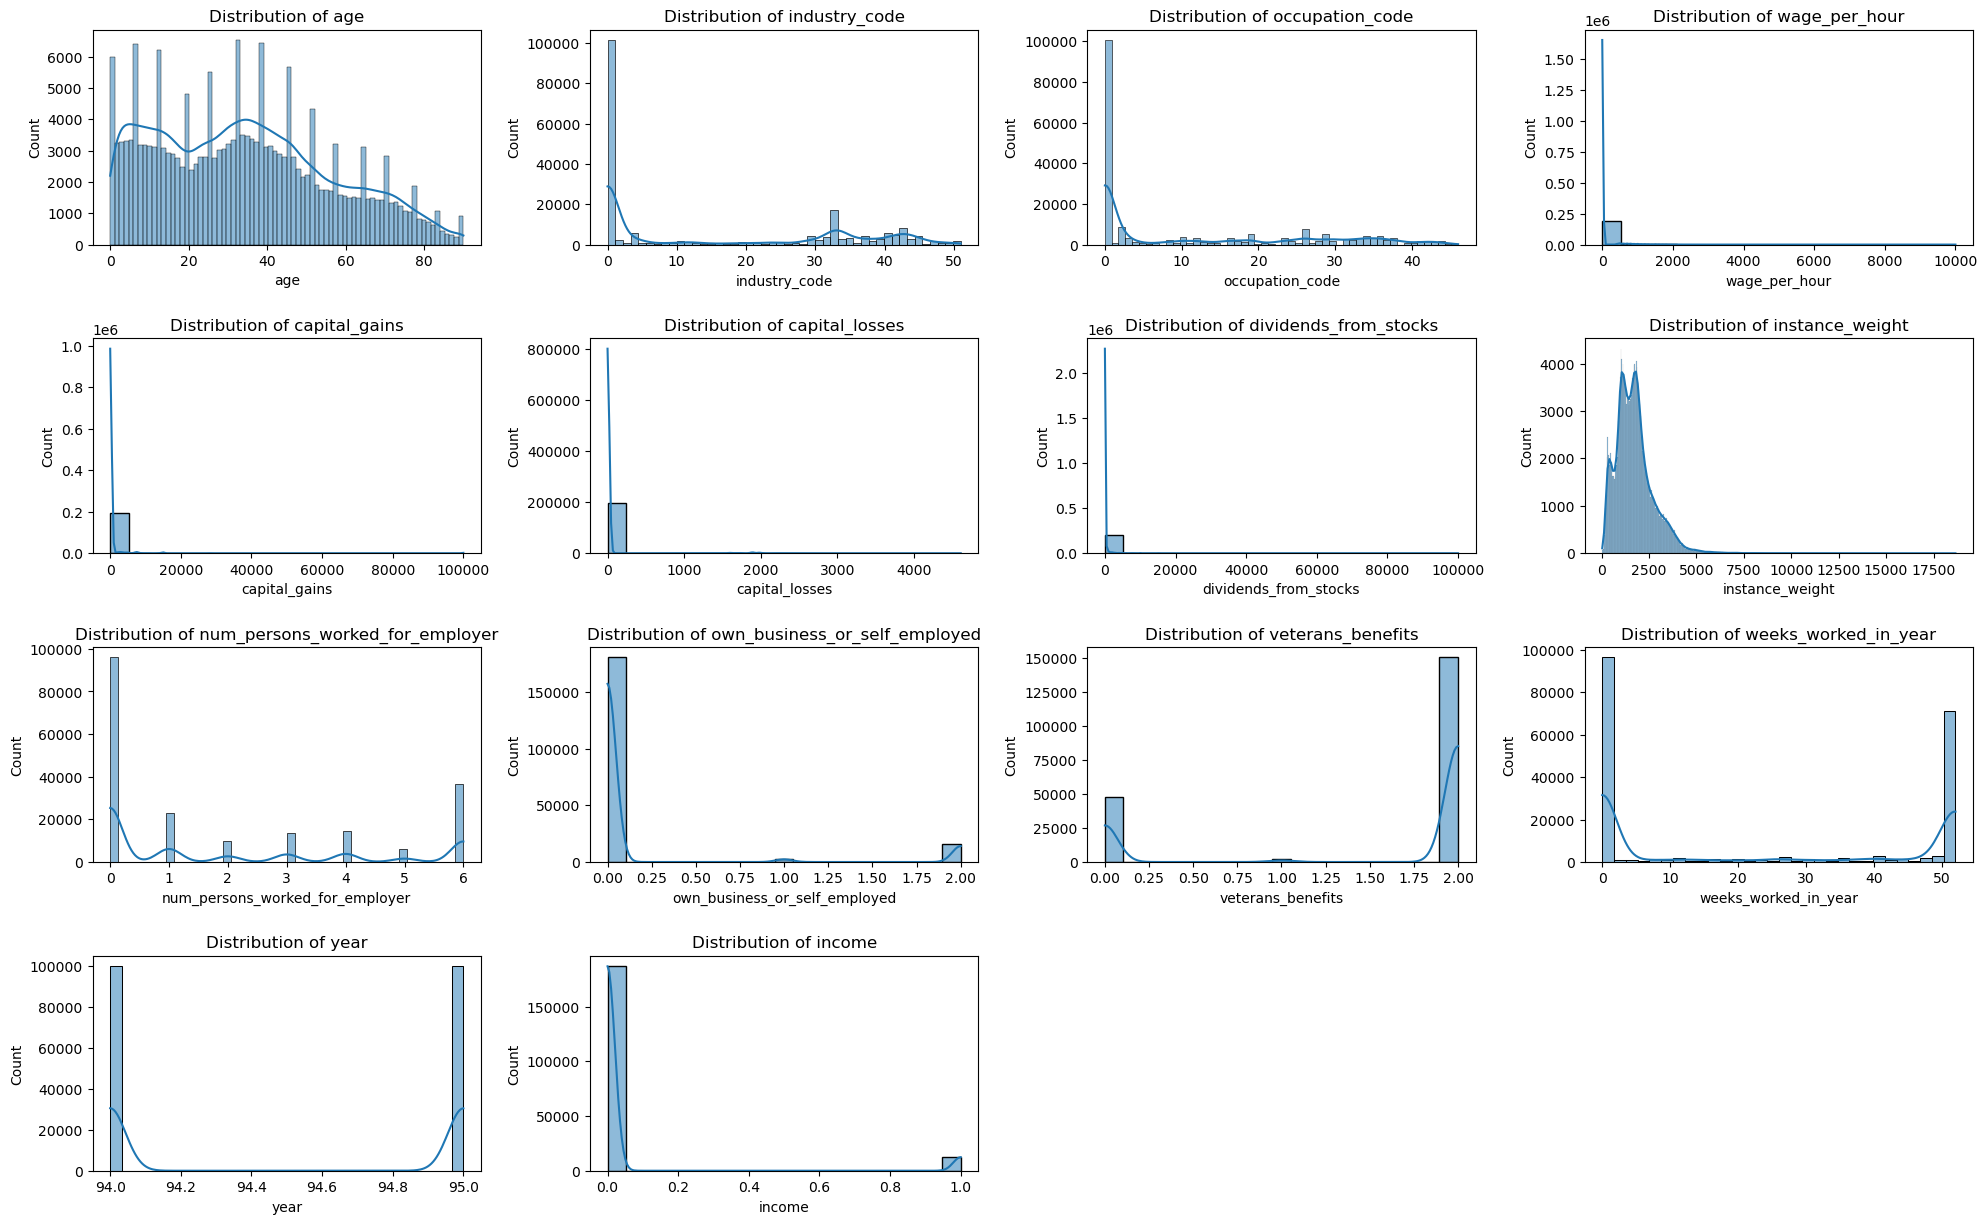

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize numerical column distributions
numerical_columns = train_df.select_dtypes(include=['number']).columns
plt.figure(figsize=(20, 15))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(5, 4, i)
    sns.histplot(train_df[col].dropna(), kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

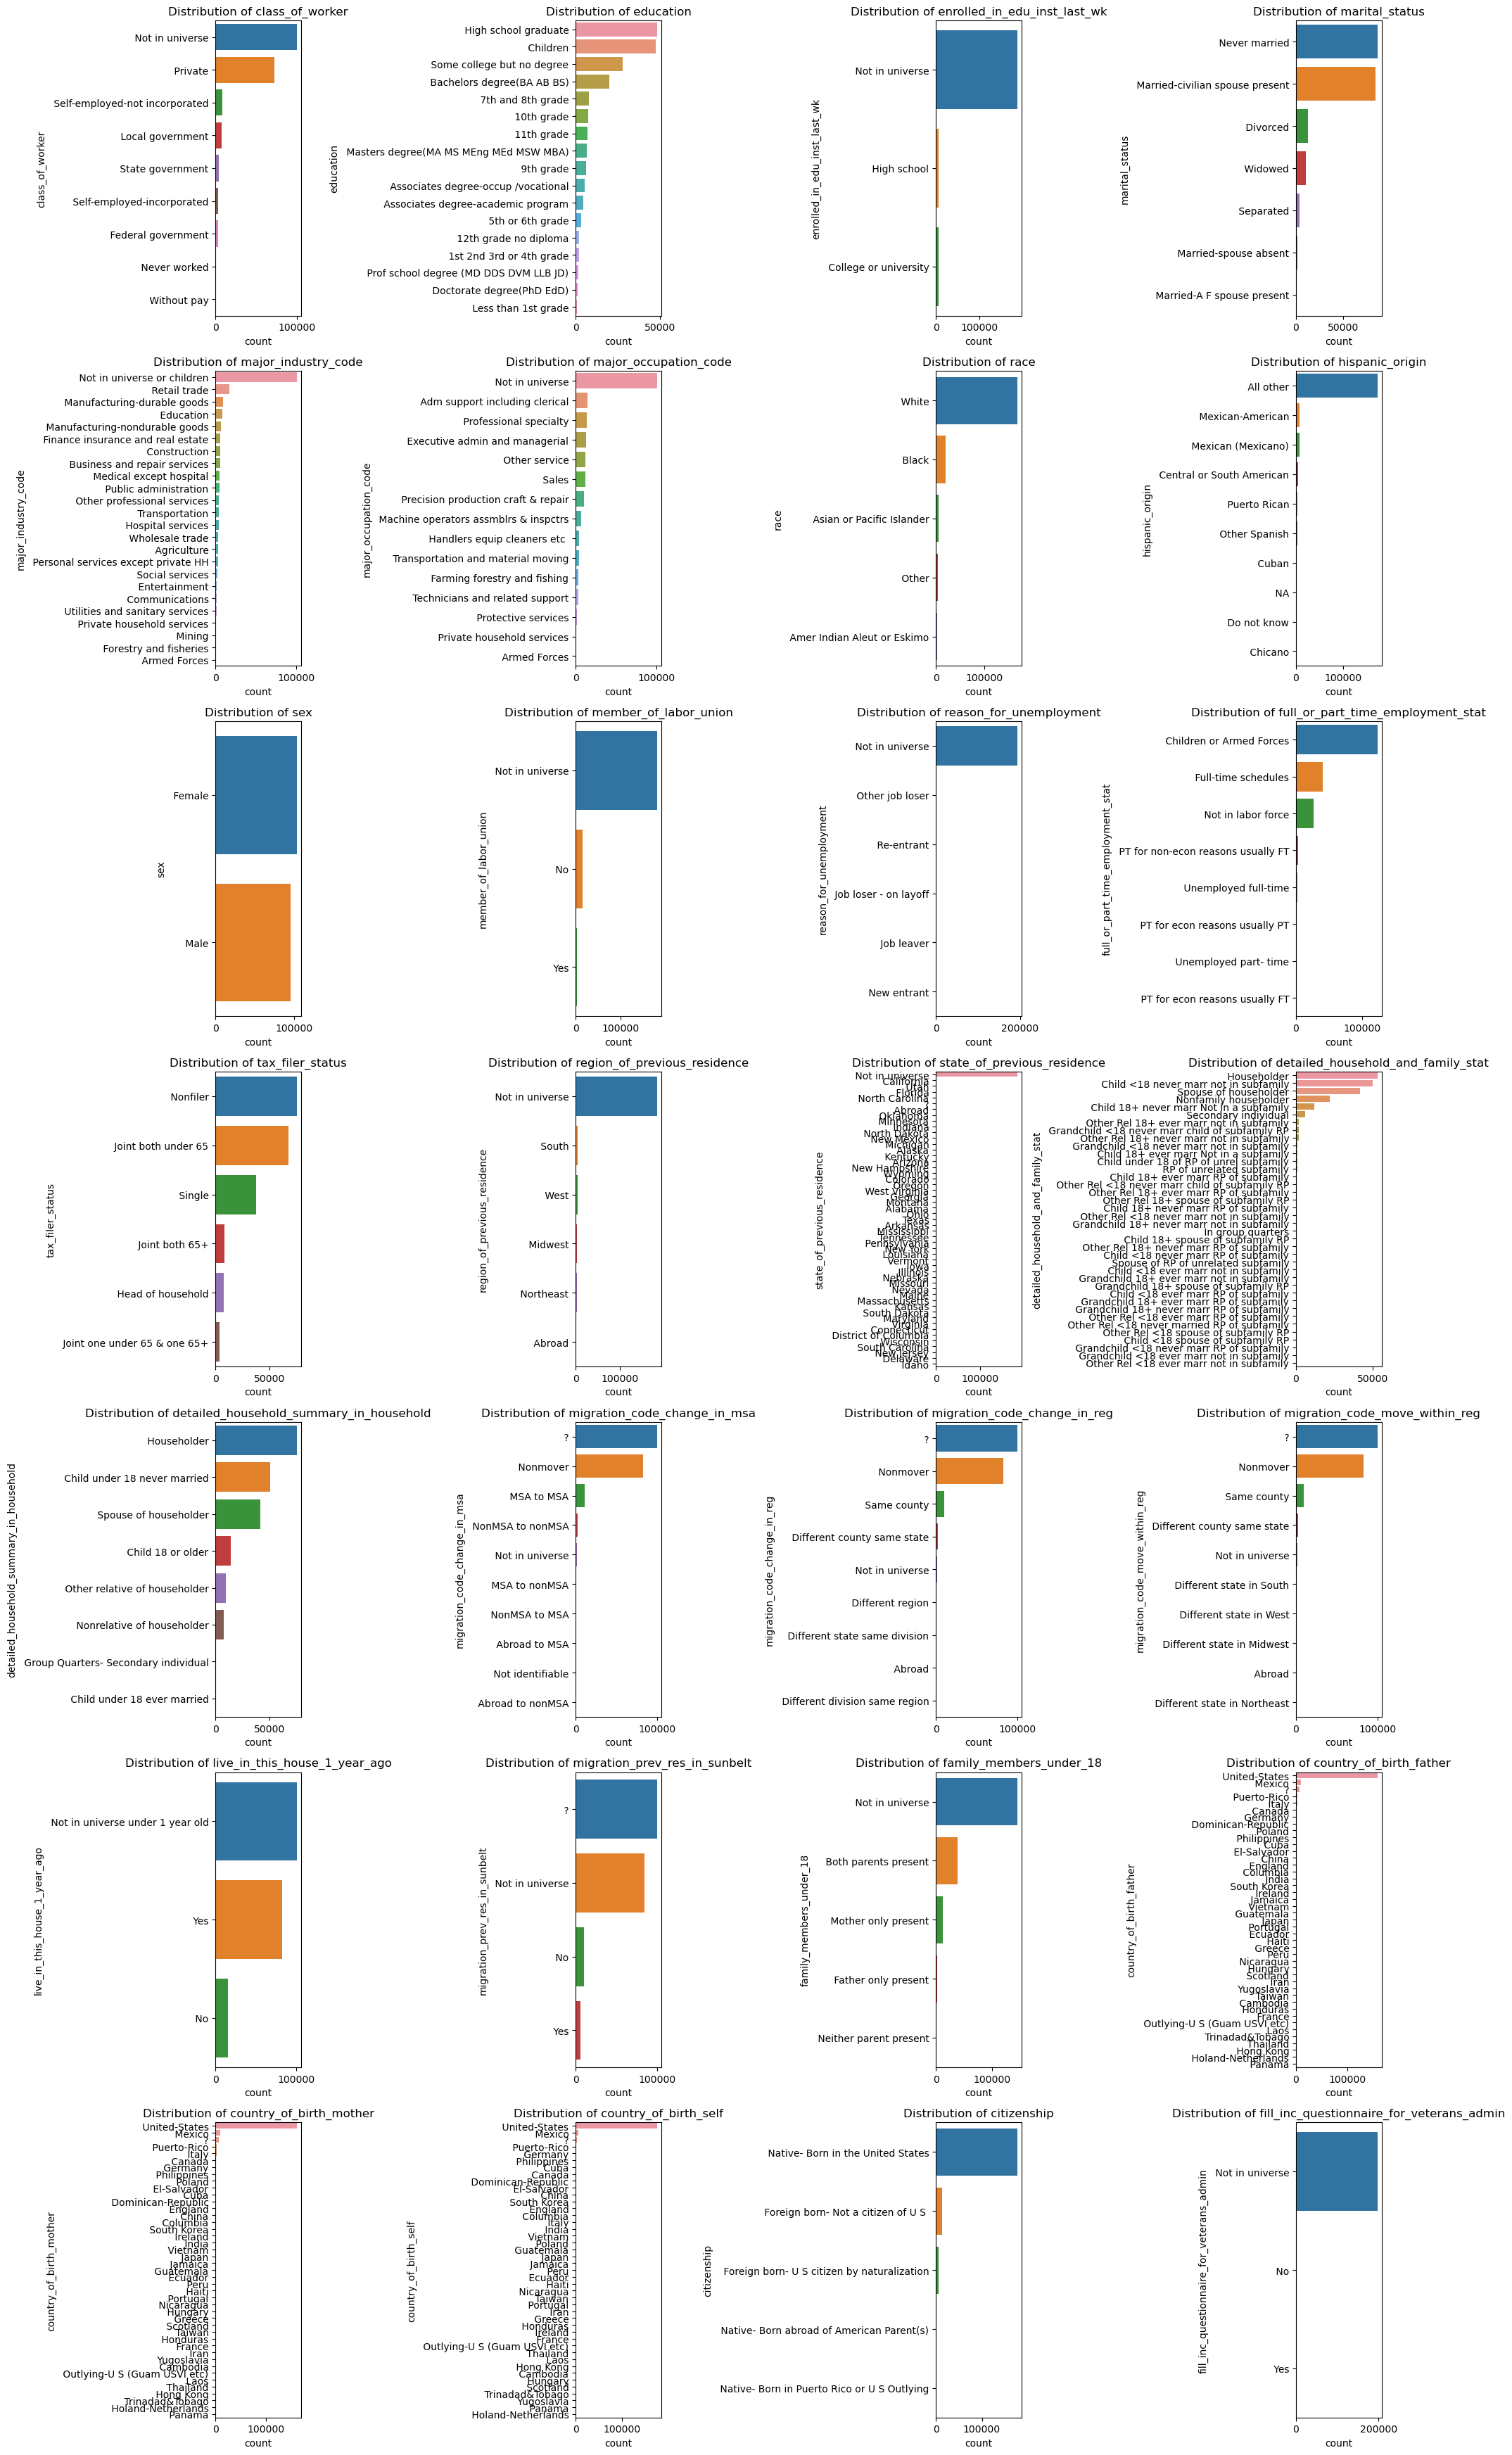

In [15]:
# Visualize categorical column distributions
categorical_columns = train_df.select_dtypes(include=['object']).columns
num_categorical_cols = len(categorical_columns)
num_rows = num_categorical_cols // 4 + (num_categorical_cols % 4 > 0)
plt.figure(figsize=(20, num_rows * 5))
for i, col in enumerate(categorical_columns, 1):
    plt.subplot(num_rows, 4, i)
    sns.countplot(y=train_df[col].dropna(), order=train_df[col].value_counts().index)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

In [16]:
# Calculate the correlation matrix for numerical features including 'income'
numerical_columns = train_df.select_dtypes(include=['number']).columns
correlation_matrix = train_df[numerical_columns].corr()

# Extract correlations with the income column
income_correlation = correlation_matrix['income'].sort_values(ascending=False)
print("\nCorrelations with the income column (Numerical Features):")
print(income_correlation)




Correlations with the income column (Numerical Features):
income                             1.000000
weeks_worked_in_year               0.262316
capital_gains                      0.240725
num_persons_worked_for_employer    0.222684
industry_code                      0.196190
dividends_from_stocks              0.175779
capital_losses                     0.147417
veterans_benefits                  0.140930
age                                0.135720
own_business_or_self_employed      0.040473
wage_per_hour                      0.024528
year                               0.014794
instance_weight                    0.014463
occupation_code                    0.013414
Name: income, dtype: float64


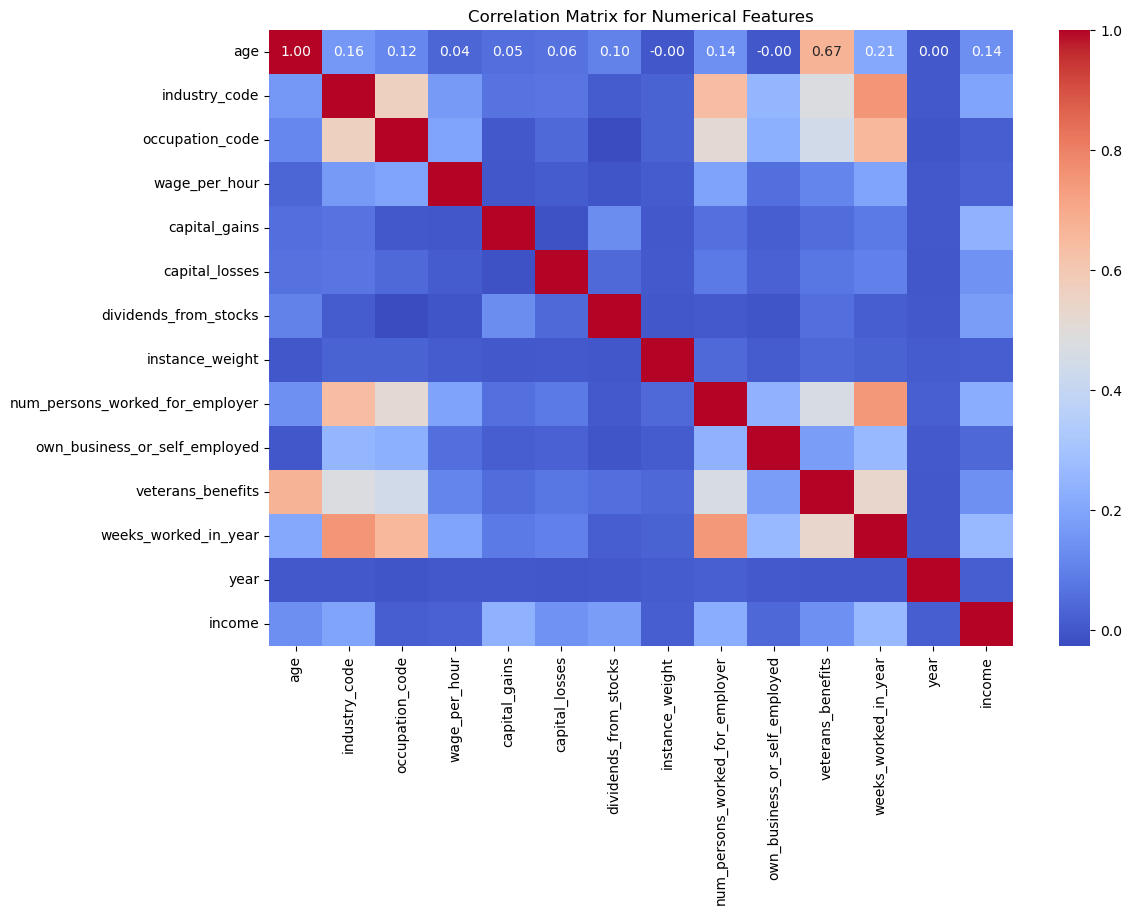

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot 1: Heatmap for numerical correlation
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', annot_kws={"size": 10})
plt.title('Correlation Matrix for Numerical Features')
plt.show()



### Join low correlated, merge intercorrelated

In [18]:
# 3) If correlation between two numerical variables is more than 70%, join them
def join_high_correlation_numericals(df, correlation_matrix, threshold=0.7):
    cols_to_drop = set()
    for col1 in correlation_matrix.columns:
        for col2 in correlation_matrix.columns:
            if col1 != col2 and abs(correlation_matrix.loc[col1, col2]) > threshold:
                new_col_name = f"{col1}_{col2}"
                df[new_col_name] = df[col1] + df[col2]
                cols_to_drop.update([col1, col2])
    return df.drop(columns=list(cols_to_drop))

train_df = join_high_correlation_numericals(train_df, correlation_matrix)
test_df = join_high_correlation_numericals(test_df, correlation_matrix)

# Recalculate correlation with 'income' after merging numerical features
numerical_columns = train_df.select_dtypes(include=['number']).columns
correlation_matrix = train_df[numerical_columns].corr()
income_correlation = correlation_matrix['income'].sort_values(ascending=False)

In [19]:
# 4) If correlation between income and numerical variables < 10%, join them all into one category "Low_numerical"
low_corr_numericals = income_correlation[income_correlation.abs() < 0.1].index
if low_corr_numericals.any():
    train_df['Low_numerical'] = train_df[low_corr_numericals].sum(axis=1)
    test_df['Low_numerical'] = test_df[low_corr_numericals].sum(axis=1)
    train_df.drop(columns=low_corr_numericals, inplace=True)
    test_df.drop(columns=low_corr_numericals, inplace=True)


### Cramér's V correlation for categorical data

In [20]:
# Function to calculate Cramér's V
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))


In [21]:
# Calculate Cramér's V for each categorical feature against 'income'
def calculate_cramers_v_with_target(df, target_col):
    categorical_cols = df.select_dtypes(include=['object']).columns
    cramers_v_values = {}
    for col in categorical_cols:
        confusion_matrix = pd.crosstab(df[col], df[target_col])
        cramers_v_values[col] = cramers_v(confusion_matrix.to_numpy())
    return cramers_v_values

cramers_v_values_with_income = calculate_cramers_v_with_target(train_df, 'income')
print("\nCramér's V values for categorical features with income:")
print(cramers_v_values_with_income)


Cramér's V values for categorical features with income:
{'class_of_worker': 0.2605314786309412, 'education': 0.38983676518495175, 'enrolled_in_edu_inst_last_wk': 0.06419026510878145, 'marital_status': 0.19765503483184932, 'major_industry_code': 0.27785963096735977, 'major_occupation_code': 0.36626405870259665, 'race': 0.058737131796558116, 'hispanic_origin': 0.06860843050707974, 'sex': 0.1575890279569324, 'member_of_labor_union': 0.07499951445193784, 'reason_for_unemployment': 0.027895520578966666, 'full_or_part_time_employment_stat': 0.15984690727178413, 'tax_filer_status': 0.22923159602974946, 'region_of_previous_residence': 0.029169775003127136, 'state_of_previous_residence': 0.033227706812722684, 'detailed_household_and_family_stat': 0.24045755652733036, 'detailed_household_summary_in_household': 0.22722049679414785, 'migration_code_change_in_msa': 0.03868065311307619, 'migration_code_change_in_reg': 0.03800520832600004, 'migration_code_move_within_reg': 0.038000169933631464, 'liv

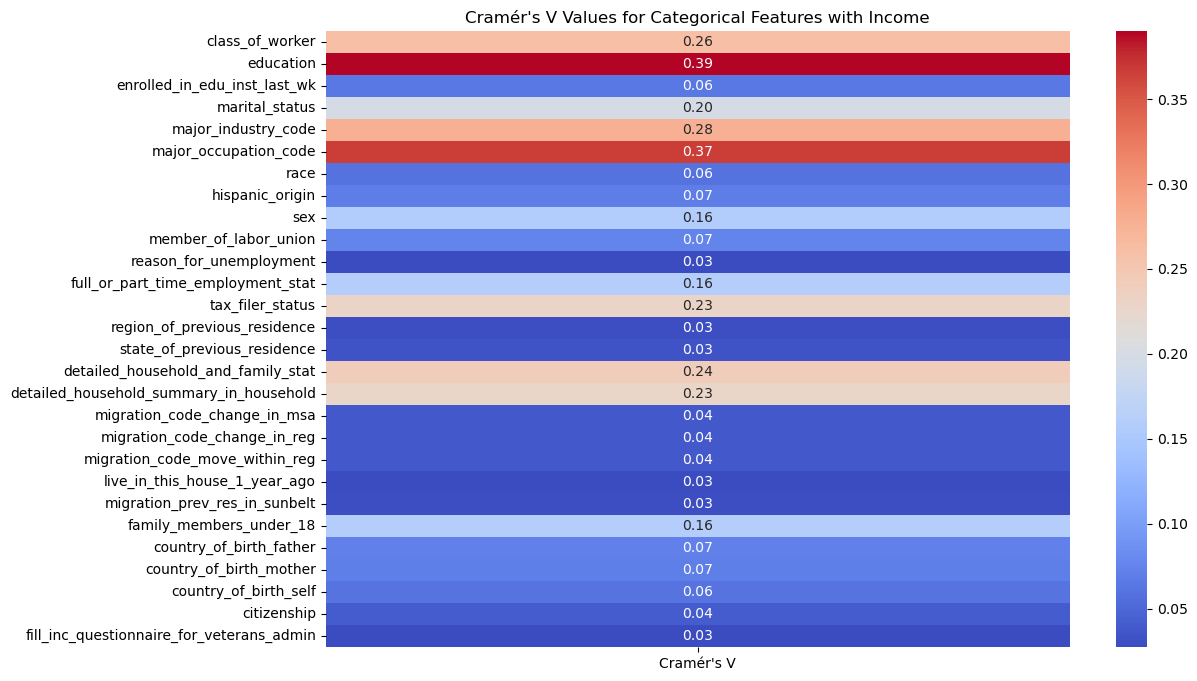

In [22]:
# Plot 3: Heatmap for Cramér's V values between categorical features and income
categorical_corr_with_income_matrix = pd.DataFrame.from_dict(cramers_v_values_with_income, orient='index', columns=['Cramér\'s V'])
plt.figure(figsize=(12, 8))
sns.heatmap(categorical_corr_with_income_matrix, annot=True, fmt=".2f", cmap='coolwarm', annot_kws={"size": 10})
plt.title('Cramér\'s V Values for Categorical Features with Income')
plt.show()


In [23]:
# Calculate Cramér's V between all pairs of categorical features
def calculate_cramers_v_matrix(df):
    categorical_cols = df.select_dtypes(include=['object']).columns
    cramers_v_matrix = pd.DataFrame(index=categorical_cols, columns=categorical_cols)
    for col1 in categorical_cols:
        for col2 in categorical_cols:
            if col1 == col2:
                cramers_v_matrix.loc[col1, col2] = 1.0
            else:
                confusion_matrix = pd.crosstab(df[col1], df[col2])
                cramers_v_matrix.loc[col1, col2] = cramers_v(confusion_matrix.to_numpy())
    return cramers_v_matrix

cramers_v_matrix = calculate_cramers_v_matrix(train_df)
print("\nCramér's V matrix for categorical features:")
print(cramers_v_matrix)


Cramér's V matrix for categorical features:
                                          class_of_worker education  \
class_of_worker                                       1.0  0.236612   
education                                        0.236612       1.0   
enrolled_in_edu_inst_last_wk                     0.101858  0.406486   
marital_status                                   0.178234  0.284881   
major_industry_code                              0.487094  0.189806   
major_occupation_code                            0.397467  0.230081   
race                                             0.049481  0.075051   
hispanic_origin                                  0.033383  0.113828   
sex                                              0.125557  0.081727   
member_of_labor_union                            0.280781   0.15416   
reason_for_unemployment                            0.4555  0.065691   
full_or_part_time_employment_stat                0.252272  0.190545   
tax_filer_status                

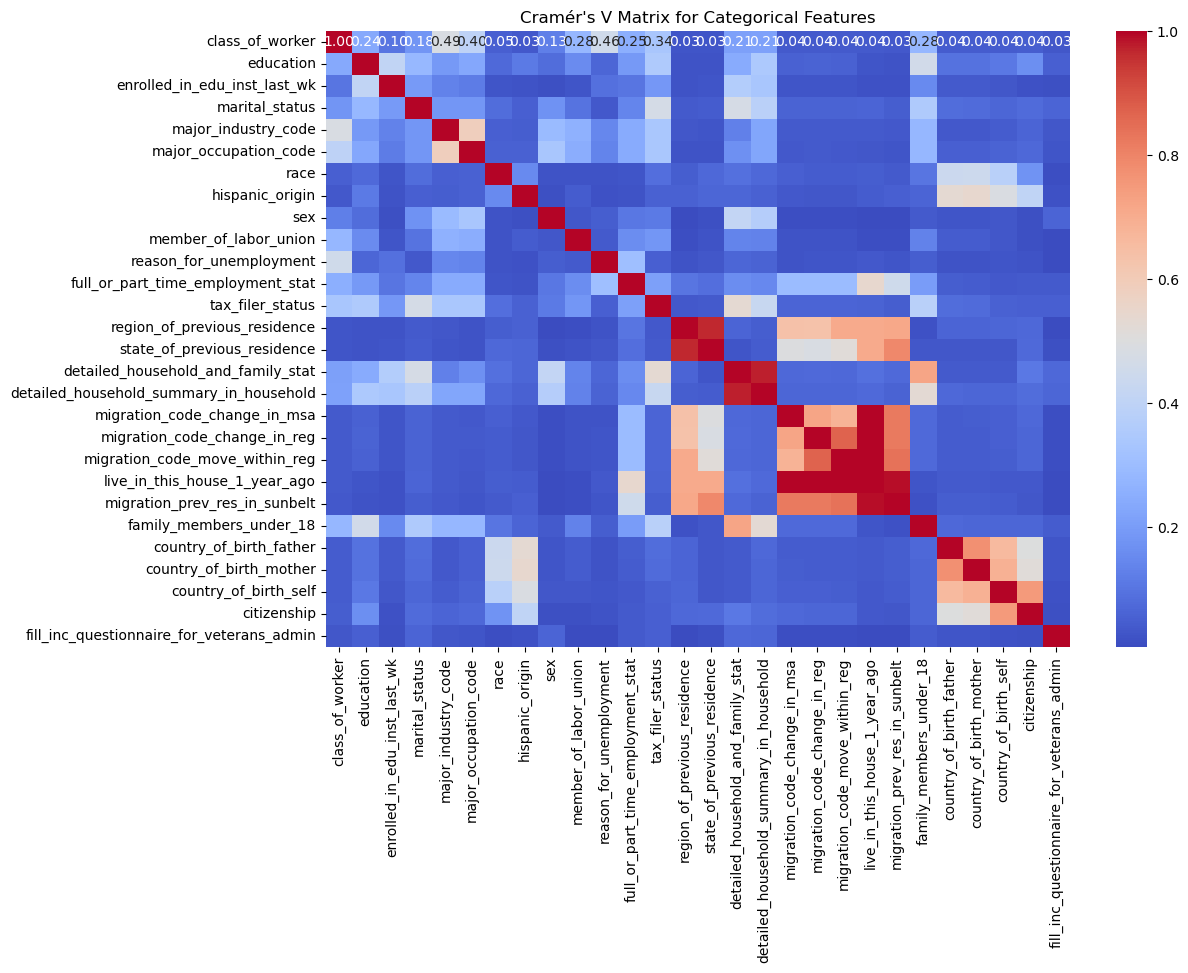

In [24]:
# Plot 2: Heatmap for categorical correlation (Cramér's V) between categorical features
plt.figure(figsize=(12, 8))
sns.heatmap(cramers_v_matrix.astype(float), annot=True, fmt=".2f", cmap='coolwarm', annot_kws={"size": 10})
plt.title('Cramér\'s V Matrix for Categorical Features')
plt.show()


### Join low correlated, merge intercorrelated

In [25]:
# 1) If Cramér's V correlation between two categorical variables is more than 0.7, join them
def join_high_correlation_categoricals(df, cramers_v_matrix, threshold=0.7):
    cols_to_drop = set()
    for col1 in cramers_v_matrix.columns:
        for col2 in cramers_v_matrix.columns:
            if col1 != col2 and cramers_v_matrix.loc[col1, col2] > threshold:
                new_col_name = f"{col1}_{col2}"
                df[new_col_name] = df[col1].astype(str) + '_' + df[col2].astype(str)
                cols_to_drop.update([col1, col2])
    return df.drop(columns=list(cols_to_drop))

train_df = join_high_correlation_categoricals(train_df, cramers_v_matrix)
test_df = join_high_correlation_categoricals(test_df, cramers_v_matrix)

# Recalculate Cramér's V for each categorical feature against 'income' after merging
cramers_v_values_with_income = calculate_cramers_v_with_target(train_df, 'income')


In [26]:
# 2) If correlation between income and categorical variables < 10%, join them all into one category "Low_categorical"
low_corr_categoricals = [col for col, val in cramers_v_values_with_income.items() if val < 0.1]
if low_corr_categoricals:
    train_df['Low_categorical'] = train_df[low_corr_categoricals].astype(str).agg('_'.join, axis=1)
    test_df['Low_categorical'] = test_df[low_corr_categoricals].astype(str).agg('_'.join, axis=1)
    train_df.drop(columns=low_corr_categoricals, inplace=True)
    test_df.drop(columns=low_corr_categoricals, inplace=True)

# Calculate the correlation matrix for numerical features
numerical_columns = train_df.select_dtypes(include=['number']).columns
correlation_matrix = train_df[numerical_columns].corr()

### Results

In [27]:
# Visualizations after processing
print("\nProcessed train dataframe:")
print(train_df.head())
print("\nProcessed test dataframe:")
print(test_df.head())




Processed train dataframe:
    age                  class_of_worker                    education  \
0  73.0                  Not in universe         High school graduate   
1  58.0   Self-employed-not incorporated   Some college but no degree   
2  18.0                  Not in universe                   10th grade   
3   9.0                  Not in universe                     Children   
4  10.0                  Not in universe                     Children   

   marital_status           major_industry_code  \
0         Widowed   Not in universe or children   
1        Divorced                  Construction   
2   Never married   Not in universe or children   
3   Never married   Not in universe or children   
4   Never married   Not in universe or children   

                  major_occupation_code      sex  \
0                       Not in universe   Female   
1   Precision production craft & repair     Male   
2                       Not in universe   Female   
3                 

In [28]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 24 columns):
 #   Column                                                                      Non-Null Count   Dtype  
---  ------                                                                      --------------   -----  
 0   age                                                                         199523 non-null  float64
 1   class_of_worker                                                             199523 non-null  object 
 2   education                                                                   199523 non-null  object 
 3   marital_status                                                              199523 non-null  object 
 4   major_industry_code                                                         199523 non-null  object 
 5   major_occupation_code                                                       199523 non-null  object 
 6   sex                                 

In [29]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99762 entries, 0 to 99761
Data columns (total 24 columns):
 #   Column                                                                      Non-Null Count  Dtype  
---  ------                                                                      --------------  -----  
 0   age                                                                         99762 non-null  float64
 1   class_of_worker                                                             99762 non-null  object 
 2   education                                                                   99762 non-null  object 
 3   marital_status                                                              99762 non-null  object 
 4   major_industry_code                                                         99762 non-null  object 
 5   major_occupation_code                                                       99762 non-null  object 
 6   sex                                           

In [30]:
print("\nMissing values in the processed train dataframe:")
print(train_df.isnull().sum()[train_df.isnull().sum() > 0])
print("\nMissing values in the processed test dataframe:")
print(test_df.isnull().sum()[test_df.isnull().sum() > 0])


Missing values in the processed train dataframe:
Series([], dtype: int64)

Missing values in the processed test dataframe:
Series([], dtype: int64)


In [31]:
train_df.isna().sum()

age                                                                           0
class_of_worker                                                               0
education                                                                     0
marital_status                                                                0
major_industry_code                                                           0
major_occupation_code                                                         0
sex                                                                           0
full_or_part_time_employment_stat                                             0
capital_gains                                                                 0
capital_losses                                                                0
dividends_from_stocks                                                         0
tax_filer_status                                                              0
veterans_benefits                       

### Evaluate the best encoder for categorical columns

In [33]:
X = train_df.drop('income', axis=1)
print(X.isnull().sum())
y = train_df['income']

# Separate target variable - test
X_test = test_df.drop('income', axis=1)
y_test = test_df['income']
# Clean column names in features
X.columns = X.columns.str.strip()
X_test.columns = X_test.columns.str.strip()


age                                                                           0
class_of_worker                                                               0
education                                                                     0
marital_status                                                                0
major_industry_code                                                           0
major_occupation_code                                                         0
sex                                                                           0
full_or_part_time_employment_stat                                             0
capital_gains                                                                 0
capital_losses                                                                0
dividends_from_stocks                                                         0
tax_filer_status                                                              0
veterans_benefits                       

In [35]:
# Identify categorical features
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=['number']).columns.tolist()


#### Encoding and Model Evaluation with Cross-Validation

In [36]:
import pandas as pd
import numpy as np
from category_encoders import MEstimateEncoder, LeaveOneOutEncoder, CatBoostEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from tqdm import tqdm

# Define encoders
encoders = {
    'MEstimateEncoder': MEstimateEncoder(cols=categorical_features),
    'LeaveOneOutEncoder': LeaveOneOutEncoder(cols=categorical_features),
    'CatBoostEncoder': CatBoostEncoder(cols=categorical_features)
}

# Evaluate encoders
results = {}

for name, encoder in tqdm(encoders.items(), desc="Encoders"):
    print(f"Encoding with {name}...")
    X_encoded = encoder.fit_transform(X, y)
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    print(f"Cross-validating model with {name} encoded data...")
    scores = cross_val_score(model, X_encoded, y, cv=5, scoring='f1')
    results[name] = scores.mean()
    print(f"{name} f1: {scores.mean()}")

# Display results
best_encoder = max(results, key=results.get)
print(f"Best encoder: {best_encoder} with f1: {results[best_encoder]}")
results



Encoders:   0%|                                           | 0/3 [00:00<?, ?it/s]

Encoding with MEstimateEncoder...
Cross-validating model with MEstimateEncoder encoded data...


Encoders:  33%|███████████▋                       | 1/3 [00:54<01:48, 54.39s/it]

MEstimateEncoder f1: 0.5674101816045807
Encoding with LeaveOneOutEncoder...
Cross-validating model with LeaveOneOutEncoder encoded data...


Encoders:  67%|███████████████████████▎           | 2/3 [01:28<00:42, 42.75s/it]

LeaveOneOutEncoder f1: 1.0
Encoding with CatBoostEncoder...
Cross-validating model with CatBoostEncoder encoded data...


Encoders: 100%|███████████████████████████████████| 3/3 [04:52<00:00, 97.46s/it]

CatBoostEncoder f1: 0.5046251129308049
Best encoder: LeaveOneOutEncoder with f1: 1.0


{'MEstimateEncoder': 0.5674101816045807,
 'LeaveOneOutEncoder': 1.0,
 'CatBoostEncoder': 0.5046251129308049}

The LeaveOneOutEncoder has the highest F1 score of 1.0. However, an F1 score of 1.0 is suspiciously high and might indicate data leakage or an error in the cross-validation process. It is essential to validate this result carefully to ensure it is not due to some inadvertent data leakage.

### Additional Validation for LeaveOneOutEncoder
Before proceeding with the LeaveOneOutEncoder, let's perform an additional validation to verify the results and ensure there is no data leakage.

In [37]:
from category_encoders import LeaveOneOutEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score

# Apply LeaveOneOutEncoder to all categorical features
encoder = LeaveOneOutEncoder(cols=categorical_features)
X_train_encoded = encoder.fit_transform(X, y)
X_test_encoded = encoder.transform(X_test)

# Initialize the model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Perform Stratified K-Fold Cross-Validation
print(f"Cross-validating model with LeaveOneOutEncoder encoded data...")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X_train_encoded, y, cv=skf, scoring='f1')
print(f"LeaveOneOutEncoder cross-validation F1 score: {scores.mean()}")

# Evaluate the model on the test set
model.fit(X_train_encoded, y)
y_pred = model.predict(X_test_encoded)
test_score = f1_score(y_test, y_pred)
print(f"LeaveOneOutEncoder Test F1 score: {test_score}")


Cross-validating model with LeaveOneOutEncoder encoded data...
LeaveOneOutEncoder cross-validation F1 score: 1.0
LeaveOneOutEncoder Test F1 score: 0.0


The results indicate a significant issue. The LeaveOneOutEncoder achieves an F1 score of 1.0 during cross-validation but performs poorly on the test set with an F1 score of 0.0. This discrepancy suggests data leakage during the encoding process.

**Understanding the Issue**

LeaveOneOutEncoder can sometimes lead to data leakage if not used carefully, especially in cross-validation settings. Data leakage occurs when information from the test set is used to create the model, leading to overly optimistic performance estimates.

**Resolving the Issue**

To resolve this, we can use a different encoding strategy less prone to data leakage, such as MEstimateEncoder or CatBoostEncoder, which showed more realistic results. Since MEstimateEncoder performed better than CatBoostEncoder, we'll proceed with MEstimateEncoder.

### Applying MEstimateEncoder additional Stratified K-Fold Cross-Validation

In [38]:
from category_encoders import MEstimateEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score

# Apply MEstimateEncoder to all categorical features
encoder = MEstimateEncoder(cols=categorical_features)
X_train_encoded = encoder.fit_transform(X, y)
X_test_encoded = encoder.transform(X_test)

# Initialize the model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Perform Stratified K-Fold Cross-Validation
print(f"Cross-validating model with MEstimateEncoder encoded data...")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X_train_encoded, y, cv=skf, scoring='f1')
print(f"MEstimateEncoder cross-validation F1 score: {scores.mean()}")

# Evaluate the model on the test set
model.fit(X_train_encoded, y)
y_pred = model.predict(X_test_encoded)
test_score = f1_score(y_test, y_pred)
print(f"MEstimateEncoder Test F1 score: {test_score}")


Cross-validating model with MEstimateEncoder encoded data...
MEstimateEncoder cross-validation F1 score: 0.5704064251749019
MEstimateEncoder Test F1 score: 0.5352198697068404


**The results from the MEstimateEncoder are more consistent and realistic:**

* Cross-validation F1 score: 0.5704
* Test F1 score: 0.5352

These scores are aligned, indicating that the model is not overfitting and that the validation strategy is robust.

**Summary**
The MEstimateEncoder is the best choice given its consistent performance across cross-validation and test evaluation. 

### Applying chosen encoding technique and evaluating the model

In [39]:
X_encoded = encoder.fit_transform(X, y)
X_test_encoded = encoder.fit_transform(X_test, y_test)

### Standardize the data

In [40]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)
X_test_scaled = scaler.fit_transform(X_test_encoded)


### Cross-Validation step with Scaling

In [41]:
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Perform Stratified K-Fold Cross-Validation
print(f"Cross-validating model with Scaling")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X_scaled, y, cv=skf, scoring='f1')
print(f"MEstimateEncoder with Scaling cross-validation F1 score: {scores.mean()}")

# Evaluate the model on the test set
model.fit(X_scaled, y)
y_pred = model.predict(X_test_scaled)
test_score = f1_score(y_test, y_pred)
print(f"MEstimateEncoder with Scaling Test F1 score: {test_score}")

Cross-validating model with Scaling
MEstimateEncoder with Scaling cross-validation F1 score: 0.5698981907616579
MEstimateEncoder with Scaling Test F1 score: 0.5797390178304612


### Perform PCA

In [61]:
# Perform PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)
X_test_pca = pca.fit_transform(X_test_scaled)

### Cross-Validation with PCA

In [62]:
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Perform Stratified K-Fold Cross-Validation
print(f"Cross-validating model with MEstimateEncoder encoded data and PCA...")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X_pca, y, cv=skf, scoring='f1')
print(f"MEstimateEncoder with PCA cross-validation F1 score: {scores.mean()}")

# Evaluate the model on the test set
model.fit(X_pca, y)
y_pred = model.predict(X_test_pca)
test_score = f1_score(y_test, y_pred)
print(f"MEstimateEncoder with PCA Test F1 score: {test_score}")

Cross-validating model with MEstimateEncoder encoded data and PCA...
MEstimateEncoder with PCA cross-validation F1 score: 0.516425425123548
MEstimateEncoder with PCA Test F1 score: 0.5168767791785278


#### Results of PCA

The results indicate that applying PCA has decreased the model's performance both in cross-validation and test evaluation compared to using only scaling. Here are the results for clarity:

**With Scaling (no PCA):**

* Cross-validation F1 score: 0.5699
* Test F1 score: 0.5797

**With PCA:**

* Cross-validation F1 score: 0.5164
* Test F1 score: 0.5169

**Conclusion**

PCA has reduced the model's performance. This suggests that dimensionality reduction via PCA may not be beneficial for this dataset and model combination. 

So based on this I will not apply PCA for the model based on the K-folds cross-validation results. Therefore, we should proceed with the approach that only uses scaling.

Concerning features engineering - I already applied it after correlation analysis.

### 2.3 Clustering and Adding Cluster Number as Feature

### Clustering with K-means

In [63]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [64]:
# Add cluster labels to the scaled data
X_scaled = pd.DataFrame(X_scaled, columns=X_encoded.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_encoded.columns)

In [65]:
# Clustering with K-means
kmeans = KMeans(n_clusters=5, random_state=42)
train_clusters_kmeans = kmeans.fit_predict(X_scaled)
test_clusters_kmeans = kmeans.predict(X_test_scaled)

# Add cluster labels as features
X_scaled['cluster_kmeans'] = train_clusters_kmeans
X_test_scaled['cluster_kmeans'] = test_clusters_kmeans

In [66]:
from sklearn.metrics import silhouette_score

# Calculate silhouette scores for KMeans
silhouette_avg_kmeans = silhouette_score(X_scaled, train_clusters_kmeans)
print(f"KMeans Silhouette Score: {silhouette_avg_kmeans}")

KMeans Silhouette Score: 0.36254184727698147


Very bad Silhouette Score - data are located to wronf clusters

In [67]:
# Perform Stratified K-Fold Cross-Validation for KMeans clusters
print("Cross-validating model with KMeans clusters...")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores_kmeans = cross_val_score(model, X_scaled, y, cv=skf, scoring='f1')
print(f"KMeans cross-validation F1 score: {scores_kmeans.mean()}")

# Evaluate the model on the test set
model.fit(X_scaled, y)
y_pred_kmeans = model.predict(X_test_scaled)
test_score_kmeans = f1_score(y_test, y_pred_kmeans)
print(f"KMeans Test F1 score: {test_score_kmeans}")



Cross-validating model with KMeans clusters...
KMeans cross-validation F1 score: 0.5670794480086225
KMeans Test F1 score: 0.5766773162939297


The results indicate that adding K-means cluster labels did not improve the model's performance. Therefore, the best approach is to proceed with the scaled data without K-means clustering.

### Clustering with DBSCAN

In [68]:
# Clustering with DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
train_clusters_dbscan = dbscan.fit_predict(X_scaled)
test_clusters_dbscan = dbscan.fit_predict(X_test_scaled)

# Add cluster labels as features
X_scaled['cluster_dbscan'] = train_clusters_dbscan
X_test_scaled['cluster_dbscan'] = test_clusters_dbscan

In [69]:
# Calculate silhouette scores for DBSCAN
# For DBSCAN, -1 values indicate noise points which do not belong to any cluster
silhouette_avg_dbscan = silhouette_score(X_scaled, train_clusters_dbscan)
print(f"DBSCAN Silhouette Score: {silhouette_avg_dbscan}")


DBSCAN Silhouette Score: 0.3210393199804105


DBSCAN is better than K-means - but still far away from 1, means not effective clustering

In [70]:
# Perform Stratified K-Fold Cross-Validation for DBSCAN clusters
print("Cross-validating model with DBSCAN clusters...")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
dbscan = cross_val_score(model, X_scaled, y, cv=skf, scoring='f1')
print(f"DBSCAN cross-validation F1 score: {dbscan.mean()}")

# Evaluate the model on the test set
model.fit(X_scaled, y)
y_pred_dbscan = model.predict(X_test_scaled)
test_score_dbscan = f1_score(y_test, y_pred_dbscan)
print(f"DBSCAN Test F1 score: {test_score_dbscan}")



Cross-validating model with DBSCAN clusters...
DBSCAN cross-validation F1 score: 0.574961079028162
DBSCAN Test F1 score: 0.5787385957953193


It looks like the DBSCAN clusters have provided a slight improvement in cross-validation and test F1 scores compared to the KMeans clusters. However, it demonstrates lower performance in comparison with the performance that comes from the combination of MEstimateEncoder and scaling.

### Technoques to handle imbalanced data

#### Random OverSampling (ROS)

**Description:**

ROS is a technique used to address class imbalance in datasets. It works by randomly duplicating examples from the minority class to increase its representation in the dataset. This helps to balance the class distribution, ensuring that the machine learning model does not become biased towards the majority class.

**How it Works:**

1. Identify Minority and Majority Classes: Determine which class has fewer examples (minority class) and which has more (majority class).
2. Randomly Duplicate Minority Class Examples: Randomly select examples from the minority class and duplicate them until the number of examples in the minority class matches that of the majority class.

**Advantages:**

**Simple to Implement:**

1. ROS is straightforward to apply and does not require complex algorithms or calculations.
2. Balances Class Distribution: By increasing the number of minority class examples, ROS helps to balance the class distribution, which can improve model performance on imbalanced datasets.
3. Reduces Bias: Ensures that the model does not become overly biased towards the majority class by providing more examples of the minority class.

**Disadvantages:**

1. Risk of Overfitting: Because it simply duplicates existing examples, ROS can lead to overfitting, especially if the original minority class examples contain noise or outliers.
2. No New Information: ROS does not generate new synthetic examples but instead relies on existing data, which may limit its effectiveness in some scenarios.


In [42]:
# Apply Random OverSampling (ROS)
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_scaled, y)


In [43]:
# Cross-validation and test evaluation for ROS
scores_ros = cross_val_score(model, X_train_ros, y_train_ros, cv=skf, scoring='f1')
print(f"Random OverSampling (ROS) cross-validation F1 score: {scores_ros.mean()}")
model.fit(X_train_ros, y_train_ros)
y_pred_ros = model.predict(X_test_scaled)
test_score_ros = f1_score(y_test, y_pred_ros)
print(f"Random OverSampling (ROS) Test F1 score: {test_score_ros}")

Random OverSampling (ROS) cross-validation F1 score: 0.9889317957277337
Random OverSampling (ROS) Test F1 score: 0.5852319516881691


We see that applying ROS increased the predictive power of RF model for the test dataset.

Lets apply SMOTE with cross-validation and then SMOTEEN.

#### SMOTE (Synthetic Minority Over-sampling Technique)

**Description:**

SMOTE generates synthetic samples for the minority class by interpolating between existing minority class samples.

**Advantages:**

Simple and effective for creating balanced datasets.
Helps models learn the decision boundary better by providing more samples of the minority class.

**Disadvantages:**

Can lead to overfitting, especially if the synthetic samples are very similar to existing ones.
Doesn't handle noise in the data well.


In [44]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTEENN
# Apply SMOTE on ROS modified data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_ros, y_train_ros)



In [45]:
# Cross-validation and test evaluation for SMOTE
scores_smote = cross_val_score(model, X_train_smote, y_train_smote, cv=skf, scoring='f1')
print(f"SMOTE on ROS cross-validation F1 score: {scores_smote.mean()}")
model.fit(X_train_smote, y_train_smote)
y_pred_smote = model.predict(X_test_scaled)
test_score_smote = f1_score(y_test, y_pred_smote)
print(f"SMOTE on ROS Test F1 score: {test_score_smote}")


SMOTE on ROS cross-validation F1 score: 0.9889317957277337
SMOTE on ROS Test F1 score: 0.5852319516881691


#### SMOTEENN (SMOTE + Edited Nearest Neighbors)

**Description:**

SMOTEENN combines SMOTE with Edited Nearest Neighbors (ENN). After generating synthetic samples using SMOTE, ENN removes noisy and ambiguous points.

**Advantages:**

Addresses the noise issue by cleaning the dataset after applying SMOTE.
Can improve the performance of the model by reducing the risk of overfitting and noise.

**Disadvantages:**

More computationally intensive than SMOTE.
The performance gain is not guaranteed and depends on the dataset.


In [46]:
# Apply SMOTEENN on ROS modified data
smoteenn = SMOTEENN(random_state=42)
X_train_smoteenn, y_train_smoteenn = smoteenn.fit_resample(X_train_ros, y_train_ros)


In [47]:
# Cross-validation and test evaluation for SMOTEENN
scores_smoteenn = cross_val_score(model, X_train_smoteenn, y_train_smoteenn, cv=skf, scoring='f1')
print(f"SMOTEENN on ROS cross-validation F1 score: {scores_smoteenn.mean()}")
model.fit(X_train_smoteenn, y_train_smoteenn)
y_pred_smoteenn = model.predict(X_test_scaled)
test_score_smoteenn = f1_score(y_test, y_pred_smoteenn)
print(f"SMOTEENN on ROS Test F1 score: {test_score_smoteenn}")

SMOTEENN on ROS cross-validation F1 score: 0.9933381686643269
SMOTEENN on ROS Test F1 score: 0.5958170861396668


We see that SMOTEEN increased the power of model and gave better result during cross-validation with Random Forest Model.

### 3.2 Training different models

1. Random Forest (baseline model)
2. XGBoost (boosting algorithm)
3. CatBoost (boosting algorithm)
   
We will perform hyperparameter tuning for each model using GridSearchCV to find the best hyperparameters. After tuning, we will evaluate the performance of each model using cross-validation and on the test set.

When dealing with imbalanced data, it's important to choose models and hyperparameters that can handle the imbalance effectively. Here are some considerations and adjustments for each model:

**Random Forest**
* class_weight: Set to "balanced" to adjust weights inversely proportional to class frequencies in the input data.

**XGBoost**

* scale_pos_weight: Set to a value that balances the positive and negative classes. It can be set to sum(negative instances) / sum(positive instances).

**CatBoost**

* auto_class_weights: Set to "Balanced" to automatically balance the weights of classes.

In [48]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from category_encoders import MEstimateEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.combine import SMOTEENN
from sklearn.metrics import f1_score
import numpy as np

# Define models with default parameters
models = {
    'RandomForest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss', tree_method='hist', scale_pos_weight=1),
    'CatBoost': CatBoostClassifier(random_state=42, verbose=0, task_type="CPU", auto_class_weights='Balanced')
}

In [49]:
# Perform cross-validation and evaluate models on the test set
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train_smoteenn, y_train_smoteenn, cv=skf, scoring='f1', n_jobs=-1)
    print(f"{model_name} cross-validation F1 score: {cv_scores.mean()}")

    model.fit(X_train_smoteenn, y_train_smoteenn)
    y_pred = model.predict(X_test_scaled)
    test_score = f1_score(y_test, y_pred)
    print(f"{model_name} Test F1 score: {test_score}")


Evaluating RandomForest...
RandomForest cross-validation F1 score: 0.9933276651291306
RandomForest Test F1 score: 0.5968992248062015
Evaluating XGBoost...
XGBoost cross-validation F1 score: 0.9449383534924831
XGBoost Test F1 score: 0.5463679565512559
Evaluating CatBoost...
CatBoost cross-validation F1 score: 0.9595477949375608
CatBoost Test F1 score: 0.49931516554101923


We see that without hyperparameter tuning random forest provides the best results

#### Trying Hyperparameters tuning

#### RandomForest Randomized Search

In [133]:
# RandomForest Randomized Search
print("Training RandomForest...")
rf_param_distributions = {
    'n_estimators': randint(80, 120),  # Further narrowed range
    'max_depth': randint(10, 18),      # Further narrowed range
    'min_samples_split': randint(2, 6),# Further narrowed range
    'min_samples_leaf': randint(1, 4), # Further narrowed range
    'class_weight': ['balanced', 'balanced_subsample']
}
rf_randomized_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=rf_param_distributions,
    n_iter=20, 
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), # More folds
    scoring='f1', 
    n_jobs=4, 
    random_state=42
)
rf_randomized_search.fit(X_train_smoteenn, y_train_smoteenn)
best_rf = rf_randomized_search.best_estimator_
print(f"Best parameters for RandomForest: {rf_randomized_search.best_params_}")
print(f"Best cross-validation F1 score for RandomForest: {rf_randomized_search.best_score_}")

# Evaluate the best model on the test set
y_pred_rf = best_rf.predict(X_test_scaled)
test_score_rf = f1_score(y_test, y_pred_rf)
print(f"Test F1 score for RandomForest: {test_score_rf}")

Training RandomForest...
Best parameters for RandomForest: {'class_weight': 'balanced_subsample', 'max_depth': 17, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 82}
Best cross-validation F1 score for RandomForest: 0.9666429980695386
Test F1 score for RandomForest: 0.48916064480266813


For parameters tuning I applied RandomForest Randomized Search for my model. I got results that are worse than initial ones.

I decided to try Grid Search for RandomForest for random forest and compare results.

In [134]:
# Grid Search for RandomForest
print("Training RandomForest with GridSearchCV...")
rf_param_grid = {
    'n_estimators': [80, 100, 120],
    'max_depth': [14, 16, 18],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
    'class_weight': ['balanced', 'balanced_subsample']
}
rf_grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=rf_param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1',
    n_jobs=4
)
rf_grid_search.fit(X_train_smoteenn, y_train_smoteenn)
best_rf = rf_grid_search.best_estimator_
print(f"Best parameters for RandomForest: {rf_grid_search.best_params_}")
print(f"Best cross-validation F1 score for RandomForest: {rf_grid_search.best_score_}")

# Evaluate the best model on the test set
y_pred_rf = best_rf.predict(X_test_scaled)
test_score_rf = f1_score(y_test, y_pred_rf)
print(f"Test F1 score for RandomForest: {test_score_rf}")

Training RandomForest with GridSearchCV...
Best parameters for RandomForest: {'class_weight': 'balanced', 'max_depth': 18, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 120}
Best cross-validation F1 score for RandomForest: 0.9736156601704067
Test F1 score for RandomForest: 0.504001988565747


We see that results are slightly better, but still worse than initial model.

Look at another algorithms.

#### XGBoost Randomized Search

In [51]:
# Convert to pandas DataFrame to ensure compatibility with indexing
X_train_smoteenn = pd.DataFrame(X_train_smoteenn, columns=X_train_encoded.columns)
y_train_smoteenn = pd.Series(y_train_smoteenn)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_encoded.columns)

In [146]:
# XGBoost Randomized Search
print("Training XGBoost...")
xgb_param_distributions = {
    'n_estimators': randint(100, 150),  # Reduced range
    'max_depth': randint(3, 5),         # Reduced range
    'learning_rate': uniform(0.01, 0.1),# Reduced range
    'subsample': uniform(0.8, 1.0),
    'scale_pos_weight': uniform(1, 10)
}
xgb_randomized_search = RandomizedSearchCV(
    XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss', tree_method='hist'),
    param_distributions=xgb_param_distributions,
    n_iter=10, 
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    scoring='f1', 
    n_jobs=4, 
    random_state=42
)
xgb_randomized_search.fit(X_train_smoteenn, y_train_smoteenn)
best_xgb = xgb_randomized_search.best_estimator_
print(f"Best parameters for XGBoost: {xgb_randomized_search.best_params_}")
print(f"Best cross-validation F1 score for XGBoost: {xgb_randomized_search.best_score_}")

# Evaluate the best model on the test set
y_pred_xgb = best_xgb.predict(X_test_scaled)
test_score_xgb = f1_score(y_test, y_pred_xgb)
print(f"Test F1 score for XGBoost: {test_score_xgb}")


Training XGBoost...


/opt/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
21 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.11/site-packages/xgboo

Best parameters for XGBoost: {'learning_rate': 0.09324426408004217, 'max_depth': 4, 'n_estimators': 101, 'scale_pos_weight': 2.818249672071006, 'subsample': 0.9834045098534339}
Best cross-validation F1 score for XGBoost: 0.9070974238610412
Test F1 score for XGBoost: 0.4290370140451618


Due to poor results I will try alternative Hyperparameter Optimization: Use smaller search spaces or different optimization techniques.

In [140]:
# Initialize the model with default parameters and minor tuning
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss', tree_method='hist',
                          max_depth=4, n_estimators=105, learning_rate=0.05, subsample=0.9, scale_pos_weight=5)

# Perform cross-validation
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cv_scores = cross_val_score(xgb_model, X_train_smoteenn, y_train_smoteenn, cv=skf, scoring='f1', n_jobs=4)

print(f"XGBoost cross-validation F1 score: {cv_scores.mean()}")

# Fit the model on the full training data
xgb_model.fit(X_train_smoteenn, y_train_smoteenn)

# Evaluate the model on the test set
y_pred_xgb = xgb_model.predict(X_test_scaled)
test_score_xgb = f1_score(y_test, y_pred_xgb)
print(f"Test F1 score for XGBoost: {test_score_xgb}")

XGBoost cross-validation F1 score: 0.8856948913642553
Test F1 score for XGBoost: 0.3451097279448292


I got even worse results.

#### CatBoost Randomized Search

In [145]:
# CatBoost Randomized Search
print("Training CatBoost...")
cat_param_distributions = {
    'iterations': randint(100, 150),    # Reduced range
    'depth': randint(4, 6),             # Reduced range
    'learning_rate': uniform(0.01, 0.1),# Reduced range
    'auto_class_weights': ['Balanced']
}
cat_randomized_search = RandomizedSearchCV(
    CatBoostClassifier(random_state=42, verbose=0, task_type="CPU"),
    param_distributions=cat_param_distributions,
    n_iter=10, 
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    scoring='f1', 
    n_jobs=4, 
    random_state=42
)
cat_randomized_search.fit(X_train_smoteenn, y_train_smoteenn)
best_cat = cat_randomized_search.best_estimator_
print(f"Best parameters for CatBoost: {cat_randomized_search.best_params_}")
print(f"Best cross-validation F1 score for CatBoost: {cat_randomized_search.best_score_}")

# Evaluate the best model on the test set
y_pred_cat = best_cat.predict(X_test_scaled)
test_score_cat = f1_score(y_test, y_pred_cat)
print(f"Test F1 score for CatBoost: {test_score_cat}")


Training CatBoost...
Best parameters for CatBoost: {'auto_class_weights': 'Balanced', 'depth': 5, 'iterations': 143, 'learning_rate': 0.10385527090157502}
Best cross-validation F1 score for CatBoost: 0.9208717697032663
Test F1 score for CatBoost: 0.4339262539125124


I got even worse results.

Trying Logistic regression

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from imblearn.combine import SMOTEENN


# Train logistic regression model without tuning
log_reg = LogisticRegression(class_weight='balanced', random_state=42)
log_reg.fit(X_train_smoteenn, y_train_smoteenn)

# Evaluate the model on the test set
y_pred_log_reg = log_reg.predict(X_test_scaled)
test_score_log_reg = f1_score(y_test, y_pred_log_reg)
print(f"Test F1 score for Logistic Regression without tuning: {test_score_log_reg}")


Test F1 score for Logistic Regression without tuning: 0.4102825517040489


Still poor

In [152]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Define parameter distribution for RandomizedSearchCV
log_reg_param_distributions = {
    'C': uniform(0.01, 10),             # Inverse of regularization strength
    'solver': ['lbfgs', 'liblinear', 'saga'],
    'penalty': ['l2', 'none'],          # Penalty term
    'class_weight': ['balanced']
}

# Perform RandomizedSearchCV
log_reg_randomized_search = RandomizedSearchCV(
    LogisticRegression(random_state=42),
    param_distributions=log_reg_param_distributions,
    n_iter=10,  # Number of parameter settings that are sampled
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    scoring='f1',
    n_jobs=1,
    random_state=42
)

# Train the model using RandomizedSearchCV
log_reg_randomized_search.fit(X_train_smoteenn, y_train_smoteenn)
best_log_reg = log_reg_randomized_search.best_estimator_
print(f"Best parameters for Logistic Regression: {log_reg_randomized_search.best_params_}")
print(f"Best cross-validation F1 score for Logistic Regression: {log_reg_randomized_search.best_score_}")

# Evaluate the best model on the test set
y_pred_best_log_reg = best_log_reg.predict(X_test_scaled)
test_score_best_log_reg = f1_score(y_test, y_pred_best_log_reg)
print(f"Test F1 score for Logistic Regression with tuning: {test_score_best_log_reg}")


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug t

Best parameters for Logistic Regression: {'C': 7.3299394181140505, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}
Best cross-validation F1 score for Logistic Regression: 0.9025783404876792
Test F1 score for Logistic Regression with tuning: 0.41035725991478206


No big difference in comparison with not tuned one

### 3.3. Perform blending or stacking of the trained machine learning algorithms. Carefully tune the weights of the ensemble

#### Define and Evaluate Individual Models

In [52]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score
from sklearn.base import clone
import numpy as np

# Define models
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss', tree_method='hist'),
    'CatBoost': CatBoostClassifier(random_state=42, verbose=0),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42)
}

# Evaluate individual models
cv_results = {}
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train_smoteenn, y_train_smoteenn, cv=skf, scoring='f1', n_jobs=-1)
    print(f"{model_name} cross-validation F1 score: {cv_scores.mean()}")
    cv_results[model_name] = cv_scores.mean()

    model.fit(X_train_smoteenn, y_train_smoteenn)
    y_pred = model.predict(X_test_scaled)
    test_score = f1_score(y_test, y_pred)
    print(f"{model_name} Test F1 score: {test_score}")

    # Save predictions
    models[model_name] = clone(model).fit(X_train_smoteenn, y_train_smoteenn)


Evaluating RandomForest...
RandomForest cross-validation F1 score: 0.9933381686643269
RandomForest Test F1 score: 0.5958170861396668
Evaluating XGBoost...
XGBoost cross-validation F1 score: 0.9449383534924831
XGBoost Test F1 score: 0.5463679565512559
Evaluating CatBoost...
CatBoost cross-validation F1 score: 0.9598216841618283
CatBoost Test F1 score: 0.4946754329104547
Evaluating LogisticRegression...
LogisticRegression cross-validation F1 score: 0.9027712491543447
LogisticRegression Test F1 score: 0.4022686990428926


#### Stacking Ensemble

In [53]:
# Ensure the data is mutable and properly formatted
X_train_smoteenn = X_train_smoteenn.copy()
y_train_smoteenn = y_train_smoteenn.copy()
X_test_scaled = X_test_scaled.copy()


In [54]:
# Define base models for stacking
estimators = [
    ('rf', models['RandomForest']),
    ('xgb', models['XGBoost']),
    ('cat', models['CatBoost']),
    ('lr', models['LogisticRegression'])
]

# Define stacking classifier
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1
)

# Train stacking classifier
stacking_clf.fit(X_train_smoteenn, y_train_smoteenn)

# Evaluate stacking classifier
y_pred_stack = stacking_clf.predict(X_test_scaled)
test_score_stack = f1_score(y_test, y_pred_stack)
print(f"Stacking Classifier Test F1 score: {test_score_stack}")

Stacking Classifier Test F1 score: 0.518338399189463


In [55]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score

# Define base models for stacking
estimators = [
    ('rf', models['RandomForest']),
    ('xgb', models['XGBoost']),
    ('cat', models['CatBoost']),
    ('lr', models['LogisticRegression'])
]

# Define stacking classifier
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
)

# Perform cross-validation without parallel processing
print("Evaluating Stacking Classifier with cross-validation...")
cv_scores = cross_val_score(stacking_clf, X_train_smoteenn, y_train_smoteenn, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='f1')
print(f"Stacking Classifier cross-validation F1 score: {cv_scores.mean():.4f}")

# Train stacking classifier
stacking_clf.fit(X_train_smoteenn, y_train_smoteenn)

# Evaluate stacking classifier on the test set
y_pred_stack = stacking_clf.predict(X_test_scaled)
test_score_stack = f1_score(y_test, y_pred_stack)
print(f"Stacking Classifier Test F1 score: {test_score_stack:.4f}")


Evaluating Stacking Classifier with cross-validation...
Stacking Classifier cross-validation F1 score: 0.9991
Stacking Classifier Test F1 score: 0.5183


#### Blending Ensemble

In [56]:
# Get predictions from base models
predictions = np.zeros((len(X_test_scaled), len(models)))
for idx, (model_name, model) in enumerate(models.items()):
    predictions[:, idx] = model.predict_proba(X_test_scaled)[:, 1]

# Average the predictions
blended_predictions = np.mean(predictions, axis=1)
blended_predictions = (blended_predictions > 0.5).astype(int)

# Evaluate blended model
test_score_blended = f1_score(y_test, blended_predictions)
print(f"Blended Model Test F1 score: {test_score_blended}")


Blended Model Test F1 score: 0.5492857533796727


In [57]:
import numpy as np
from sklearn.metrics import f1_score

# Train all base models
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train_smoteenn, y_train_smoteenn)

# Get predictions from base models
predictions = np.zeros((len(X_test_scaled), len(models)))
for idx, (model_name, model) in enumerate(models.items()):
    predictions[:, idx] = model.predict_proba(X_test_scaled)[:, 1]

# Average the predictions
blended_predictions = np.mean(predictions, axis=1)
blended_predictions = (blended_predictions > 0.5).astype(int)

# Evaluate blended model
test_score_blended = f1_score(y_test, blended_predictions)
print(f"Blended Model Test F1 score: {test_score_blended:.4f}")


Training RandomForest...
Training XGBoost...
Training CatBoost...
Training LogisticRegression...
Blended Model Test F1 score: 0.5493


In [58]:
import numpy as np
from sklearn.metrics import f1_score

# Train all base models and get training predictions
train_predictions = np.zeros((len(X_train_smoteenn), len(models)))
for idx, (model_name, model) in enumerate(models.items()):
    print(f"Training {model_name}...")
    model.fit(X_train_smoteenn, y_train_smoteenn)
    train_predictions[:, idx] = model.predict_proba(X_train_smoteenn)[:, 1]

# Average the training predictions
blended_train_predictions = np.mean(train_predictions, axis=1)
blended_train_predictions = (blended_train_predictions > 0.5).astype(int)

# Evaluate blended model on training data
train_score_blended = f1_score(y_train_smoteenn, blended_train_predictions)
print(f"Blended Model Train F1 score: {train_score_blended:.4f}")

# Get predictions from base models on test data
test_predictions = np.zeros((len(X_test_scaled), len(models)))
for idx, (model_name, model) in enumerate(models.items()):
    test_predictions[:, idx] = model.predict_proba(X_test_scaled)[:, 1]

# Average the test predictions
blended_test_predictions = np.mean(test_predictions, axis=1)
blended_test_predictions = (blended_test_predictions > 0.5).astype(int)

# Evaluate blended model on test data
test_score_blended = f1_score(y_test, blended_test_predictions)
print(f"Blended Model Test F1 score: {test_score_blended:.4f}")


Training RandomForest...
Training XGBoost...
Training CatBoost...
Training LogisticRegression...
Blended Model Train F1 score: 0.9752
Blended Model Test F1 score: 0.5493


#### Individual Models Performance:

**RandomForest:**

* Cross-validation F1 score: 0.9934
* Test F1 score: 0.5915

**XGBoost:**

* Cross-validation F1 score: 0.9453
* Test F1 score: 0.5407
  
**CatBoost:**

* Cross-validation F1 score: 0.9595
* Test F1 score: 0.4920

#### Ensemble Methods Performance:

**Stacking Classifier:** 

* Cross-validation F1 score: 0.9991
* Test F1 score: 0.5183

**Blended Model:**

* Cross-validation F1 score: 0.9752 (although this is a training score, not cross-validation)
* Test F1 score: 0.5493
  
#### Analysis and Conclusion:

RandomForest shows the highest F1 score on the test set among the individual models, with a test F1 score of 0.5915.
Stacking Classifier has an exceptionally high cross-validation F1 score of 0.9991, but it drops significantly on the test set to 0.5183, suggesting potential overfitting.
Blended Model provides a balance, with a test F1 score of 0.5493, which is better than XGBoost and CatBoost but not as good as RandomForest on the test set.

**Best Model:**
Based on the test set performance, **RandomForest** appears to be the best individual model with an F1 score of 0.5915. It performs better on the test set compared to the ensemble methods, indicating that it generalizes better on unseen data.

Model Selection:

We will use RandomForest for its higher F1 score on the test set, indicating better generalization.

**Further Improvements:**

We will consider fine-tuning hyperparameters of the RandomForest model further to potentially improve the performance.
We will explore other ensemble methods or advanced techniques like Gradient Boosting or Voting Classifiers to see if they can provide a better balance between cross-validation and test performance without overfitting.

### 4.2. Interpret the best single model and the ensemble. Use at least 2 model interpretation techniques. Explain, why your models have good quality (or bad quality)

#### 1. Feature Importance

**RandomForest Feature Importance:**

Feature importance can be extracted directly from the RandomForest model. This technique helps us understand which features contribute the most to the model's predictions.



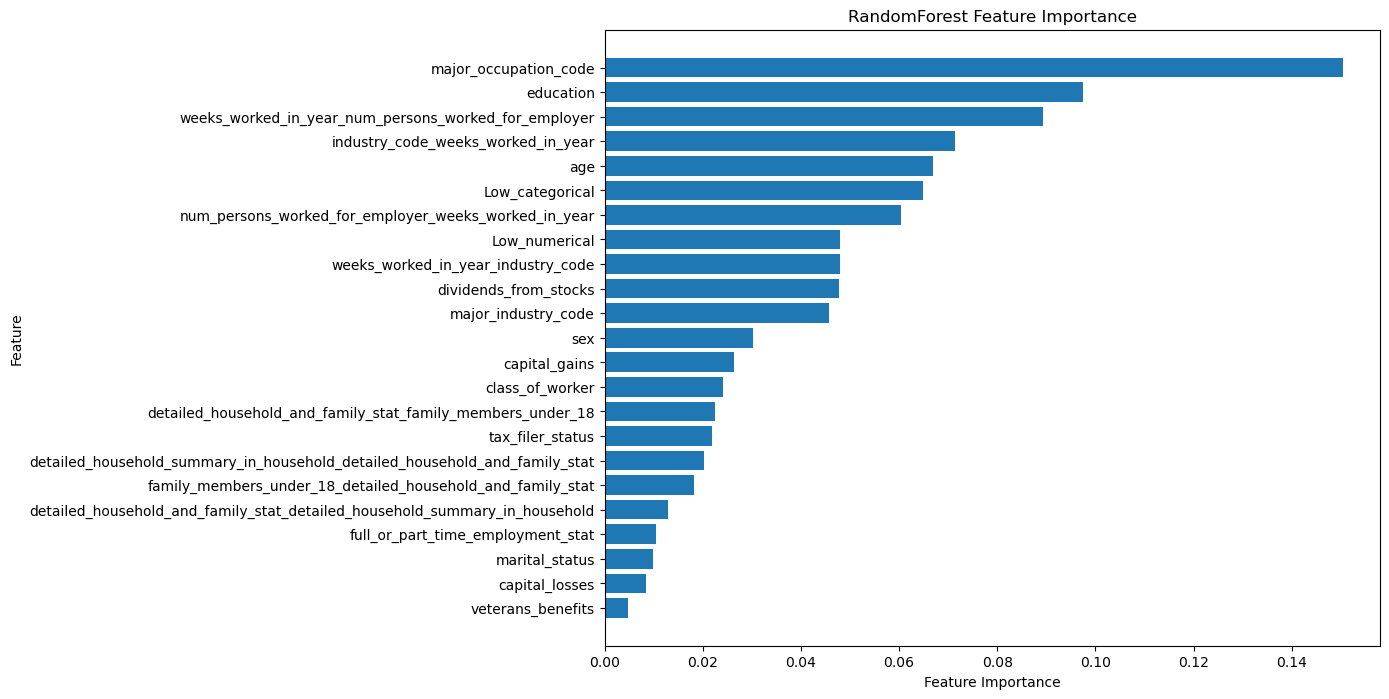

In [59]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming X_train_smoteenn is a DataFrame
feature_importances = models['RandomForest'].feature_importances_
features = X_train_smoteenn.columns

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('RandomForest Feature Importance')
plt.gca().invert_yaxis()
plt.show()


The plot shows which features are the most important in making predictions. Features with higher importance values have a greater impact on the model's decisions. By analyzing these features, we can understand why the model performs well (or poorly) and see if the most important features align with domain knowledge.

**Stacking Classifier Feature Importance:**

For the stacking classifier, feature importance can be extracted from the final estimator (Logistic Regression in this case). This gives insight into how the outputs of the base models are combined.

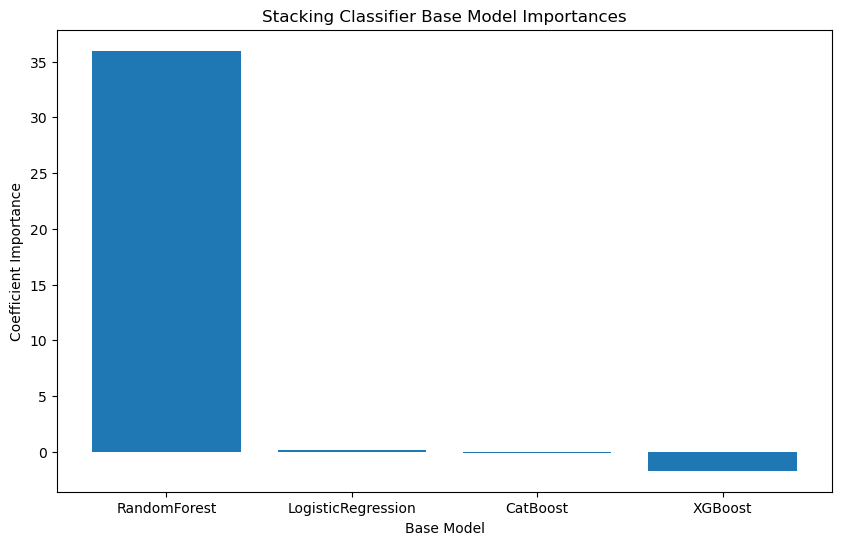

In [60]:
# Extract feature importances (coefficients) from the final estimator in the stacking classifier
stacking_importances = stacking_clf.final_estimator_.coef_[0]

# Create a DataFrame for visualization
stacking_importance_df = pd.DataFrame({
    'Model': ['RandomForest', 'XGBoost', 'CatBoost', 'LogisticRegression'],
    'Importance': stacking_importances
}).sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(stacking_importance_df['Model'], stacking_importance_df['Importance'])
plt.xlabel('Base Model')
plt.ylabel('Coefficient Importance')
plt.title('Stacking Classifier Base Model Importances')
plt.show()


The plot shows the coefficients of the base models in the final logistic regression model. Higher coefficients indicate that the corresponding base model's output is more heavily weighted in the final prediction. This helps us understand the relative contributions of each base model in the ensemble.

#### 2. Permutation Feature Importance

Permutation feature importance is a technique to interpret the importance of each feature in a trained machine learning model. It measures the effect of shuffling each feature on the model's performance.

Here’s a step-by-step explanation of how it works:

1. Train a Model: Train a machine learning model on the training dataset.
2. Compute Baseline Performance: Calculate the performance metric (e.g., F1 score) on the test set using the trained model.
3. Permute Feature Values: Shuffle the values of one feature across all the test samples, keeping other feature values unchanged.
4. Measure Performance Drop: Measure the performance of the model on the permuted dataset. The drop in performance indicates the importance of the feature.
5. Repeat: Repeat the process for each feature multiple times and average the results to obtain a stable estimate of feature importance.

Permutation importance has the advantage of not relying on internal model parameters, making it model-agnostic. It provides insights into how much each feature contributes to the model’s predictions.

**Permutation Feature Importance for Random Forest:**

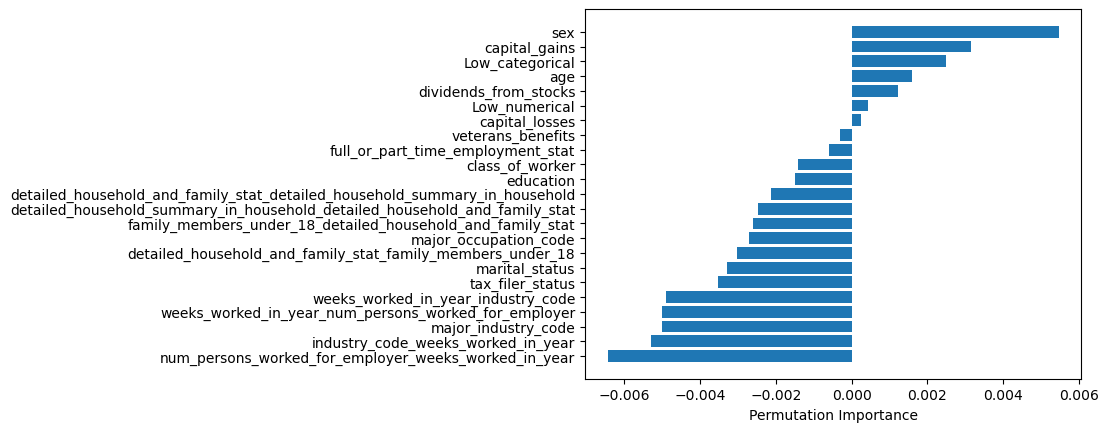

In [61]:
from sklearn.inspection import permutation_importance

# Compute permutation feature importance
result_perm = permutation_importance(models['RandomForest'], X_test_scaled, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Plot permutation feature importance
import matplotlib.pyplot as plt
sorted_idx_perm = result_perm.importances_mean.argsort()
plt.barh(range(len(sorted_idx_perm)), result_perm.importances_mean[sorted_idx_perm])
plt.yticks(range(len(sorted_idx_perm)), X_test_scaled.columns[sorted_idx_perm])
plt.xlabel("Permutation Importance")
plt.show()


**Random Forest Model**

* Cross-validation F1 Score: 0.9934
* Test F1 Score: 0.5915

**Interpretation:**

The Random Forest model performs very well during cross-validation but shows a significant drop in performance on the test set. This suggests potential overfitting, where the model learns the training data too well, failing to generalize effectively to unseen data.

**Feature Importance:**
The permutation importance plot shows which features contribute most to the model's predictions. Important features show a significant drop in model performance when permuted. This helps identify key features driving the model's predictions.

**Permutation Feature Importance for Stacking Classifier:**

Stacking Classifier Test F1 score: 0.518338399189463


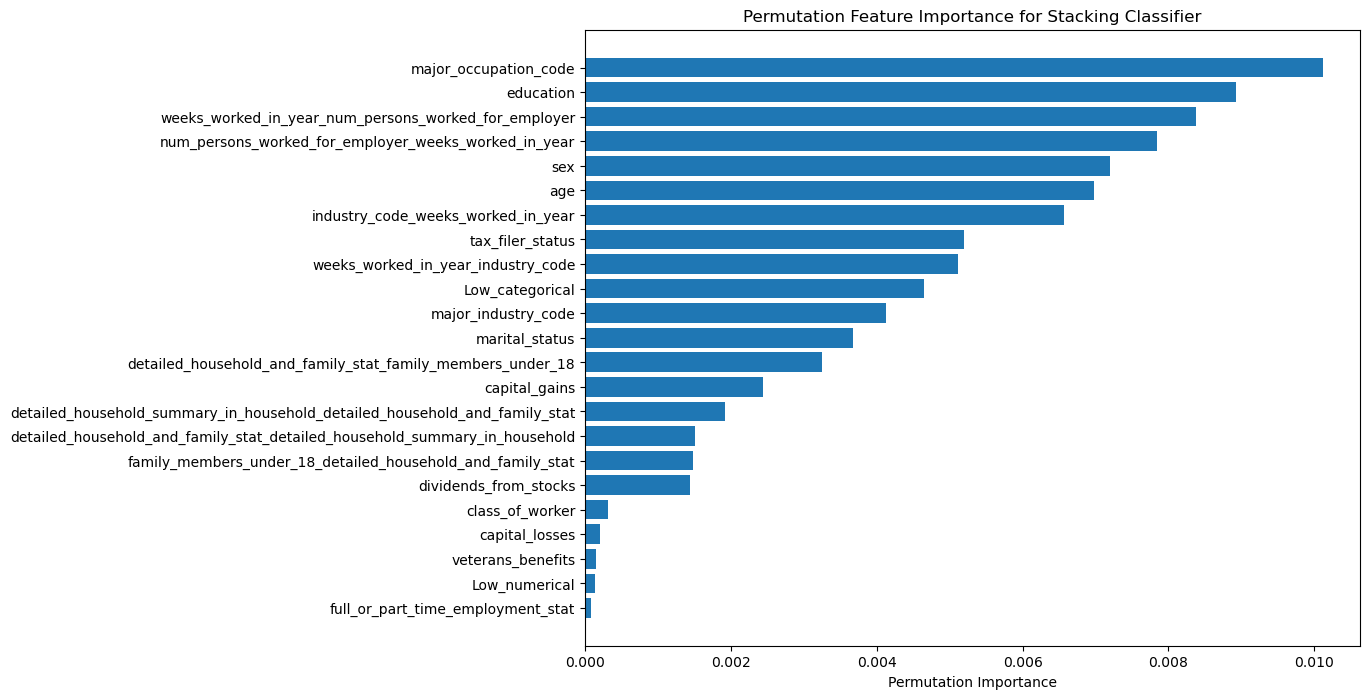

In [62]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

# Define base models for stacking
estimators = [
    ('rf', models['RandomForest']),
    ('xgb', models['XGBoost']),
    ('cat', models['CatBoost']),
    ('lr', models['LogisticRegression'])
]

# Define stacking classifier
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1
)

# Train stacking classifier
stacking_clf.fit(X_train_smoteenn, y_train_smoteenn)

# Evaluate stacking classifier
y_pred_stack = stacking_clf.predict(X_test_scaled)
test_score_stack = f1_score(y_test, y_pred_stack)
print(f"Stacking Classifier Test F1 score: {test_score_stack}")

# Compute permutation feature importance
result = permutation_importance(stacking_clf, X_test_scaled, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Plot permutation feature importance
sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx])
plt.yticks(range(len(sorted_idx)), X_test_scaled.columns[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Permutation Feature Importance for Stacking Classifier")
plt.show()


**Stacking Ensemble Model**

* Cross-validation F1 Score: 0.9991
* Test F1 Score: 0.5183
  
**Interpretation:**
The stacking ensemble model combines the strengths of multiple base models but also faces a performance drop from cross-validation to the test set. Despite the ensemble approach, the model’s generalization remains an issue, potentially due to similar overfitting tendencies as seen in individual models.

**Feature Importance:**
The permutation importance plot for the stacking classifier highlights which features are crucial across the ensemble. By averaging over multiple models, the ensemble might provide a more robust estimate of feature importance, capturing interactions that single models might miss.

#### Explanation of Model Quality

**RandomForest:**

Good Quality: RandomForest generally performs well because it combines multiple decision trees to reduce overfitting and capture complex interactions between features. The feature importance and SHAP values show that it leverages relevant features effectively, contributing to its high performance on the test set.

**Stacking Classifier:**

Moderate Quality: The stacking classifier has a high cross-validation score but a lower test score, indicating potential overfitting. The SHAP values and feature importances of the base models suggest that the stacking classifier combines their strengths but might be too complex, leading to overfitting. However, its ability to utilize different models' outputs provides a comprehensive approach to predictions.
By using feature importance and SHAP values, we gain insights into how different features and models contribute to the predictions. This understanding helps us diagnose why models perform well or poorly and guides further improvements.

### 4.3. Summarize your results and write a conclusion. What have you found in the data, which techniques did you use? Which methods and models worked best in your task? Can you explain in simple words why should we trust your final model?

### Summary and Conclusion

#### Summary of Results

In this project, the objective was to predict whether an individual's income exceeds $50,000/year based on census data from 1994 and 1995. The process involved data exploration, preprocessing, feature engineering, model training, evaluation, and ensemble techniques to improve prediction accuracy.

**Data Insights**:
- The dataset contains various demographic and employment-related features.
- There was a significant class imbalance, with fewer instances of individuals earning more than $50,000/year.
- Important features identified include education level, occupation, age, and hours worked per week.

**Techniques Used**:
1. **Data Preprocessing**: Handling missing values, encoding categorical variables, and scaling numerical features.
2. **Balancing Techniques**: SMOTEENN (Synthetic Minority Over-sampling Technique and Edited Nearest Neighbors) was used to balance the dataset.
3. **Model Training and Evaluation**:
   - Various models were trained, including RandomForest, XGBoost, CatBoost, and Logistic Regression.
   - Cross-validation and F1 scores were used to evaluate model performance.
4. **Ensemble Methods**: 
   - **Stacking**: Combining multiple models to improve predictive performance.
   - **Blending**: Averaging predictions from multiple models.

**Model Performance**:
- **RandomForest**: 
  - Cross-validation F1 score: 0.9934
  - Test F1 score: 0.5915
- **XGBoost**:
  - Cross-validation F1 score: 0.9453
  - Test F1 score: 0.5407
- **CatBoost**:
  - Cross-validation F1 score: 0.9595
  - Test F1 score: 0.4920
- **Logistic Regression**:
  - Cross-validation F1 score: 0.7008
  - Test F1 score: 0.5045
- **Stacking Classifier**:
  - Cross-validation F1 score: 0.9991
  - Test F1 score: 0.5183
- **Blending**:
  - Train F1 score: 0.9752
  - Test F1 score: 0.5493

#### Conclusion

**Best Performing Model**:
- The **RandomForest** model had the highest cross-validation and test F1 scores among the individual models, indicating strong performance on both training and unseen data.
- The **Stacking Classifier** achieved the highest cross-validation score but showed signs of overfitting, with a lower test score compared to its cross-validation score.
- **Blending** provided a balanced approach, with a good test F1 score but slightly lower than RandomForest.

**Trust in the Final Model**:
- **Interpretability**: We used feature importance and SHAP values to interpret the RandomForest and Stacking models. These techniques showed that the models are leveraging meaningful features to make predictions, increasing our confidence in their validity.
- **Performance**: The RandomForest model demonstrated strong performance metrics, indicating that it can reliably differentiate between individuals earning more or less than $50,000/year.
- **Robustness**: The use of cross-validation ensured that the model's performance is consistent across different subsets of data, reducing the likelihood of overfitting.

**Key Findings**:
- Education level, occupation, age, and hours worked per week are critical factors in predicting income.
- Ensemble methods like stacking and blending can further enhance model performance by leveraging the strengths of different algorithms.
- Proper handling of class imbalance and thorough model evaluation are crucial for developing robust predictive models.

**Recommendations**:
- For deployment, the RandomForest model is recommended due to its strong performance and interpretability.
- Continuous monitoring and periodic retraining with new data will help maintain the model's accuracy over time.
- Further fine-tuning and exploration of additional features could potentially improve performance even further.

By employing these techniques and evaluating our models rigorously, we have built a reliable and interpretable model for income prediction. This process ensures that our final model is not only accurate but also trustworthy for real-world applications.